# Abstract  
Flight delays cost airlines and passengers tens of billions of dollars each year. These costs can be mitigated by planning ahead for delays to avoid issues such as passengers missing connections or lower aircraft utilization. Therefore, we tackled this problem by answering the question: **Given flight and weather information known two hours ahead of planned departure time, will a flight depart on time (within 15 minutes of scheduled departure) or will it be delayed or cancelled?** In this notebook, we answered the question using machine learning with Spark, a large-scale data processing analytics engine, to handle the dataset of more than 30,000,000 rows. Our discussions include exploratory data analysis that guided feature engineering efforts. Additionally, we worked with and tuned different algorithms such as logistic regression, decision tree, random forest, and gradient boosted tree.  Our final model was a tuned gradient boosted tree that utilized Principal Components Analysis (PCA) for dimensionality reduction. This model achieved an accuracy of 0.652 and an F1 score of 0.458.

In [0]:
#Import packages
from pyspark.sql import functions as f
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType, NullType, ShortType, DateType, BooleanType, BinaryType, FloatType
from pyspark.sql import SQLContext
from pyspark.sql.functions import isnan, when, count, col, udf, date_trunc, max as max_
from pyspark.ml.feature import Bucketizer
from pyspark.sql.types import TimestampType
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pytz import timezone
import pytz
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler
from distutils.version import LooseVersion
from pyspark.ml.classification import LogisticRegression, LogisticRegressionModel
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import DecisionTreeClassifier, DecisionTreeClassificationModel
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier, GBTClassificationModel
from itertools import chain
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import PCA

sqlContext = SQLContext(sc)

# 1. Question Formulation

Flight delays in the U.S. cost airlines and passengers tens of billions of dollars each year\\(^1\\). While some of those costs are inevitable, others can be prevented by early flight delay detection. Both airlines and passengers have a vested interest in knowing early if flights will be delayed. Some of the largest costs are due to passengers missing connections and airlines padding schedules, resulting in lower aircraft utilization and higher pilot wages\\(^1\\). By predicting flight delays early, both airlines and passengers can minimize their additional costs by planning ahead. Passengers can start to plan connections (flights, trains, other transportation) accordingly and airlines can do their best to prevent further delays. Some common delay reasons are crew rest restrictions or waiting for a crew or aircraft. If airlines know one flight will be delayed, they can communicate with taxi traffic coordinators and prepare for the possibility of needing a new crew or aircraft for that flight and following flights.

We have focused our efforts on predicting flight delays just two hours prior to scheduled departure and have designed a model using the gradient boosted tree algorithm to answer the question:

**Given flight and weather information known two hours ahead of scheduled departure time, will a flight depart on time (within 15 minutes of scheduled departure) or not?**

The usage of "delay" throughout this project will include both flight departures that are delayed at least 15 minutes or cancelled. We’ve included cancelled flights because they have similar costly effects to delayed flights. We have treated this problem as a binary classification where a positive outcome in our model will represent a delay or cancellation. The gradient boosted tree is appropriate for this business problem because it can have a binary outcome, handle a high volume of features both categorical and numerical and is able to capture interactions. In addition, GBTs are robust to missing values so, while we did handle missing values in our pipeline, it future iterations of flight delay prediction where not all feature values are known at the time of prediction, a GBT could still make a prediction.

The flight data used in predicting flight delays are obtained from the Reporting Carrier On-Time Performance\\(^2\\) dataset provided by the Bureau of Transportation Statistics from 2015 to 2019. We also used a subset of the flight data set spanning from January 2015 through March 2015 with flights departing from Chicago O'Hare and Atlanta Hartsfield-Jackson for initial exploration and baseline model testing. We will refer to that dataset as the "3 month airline data". In addition, weather data from the National Oceanic and Atmospheric Administration (NOAA)\\(^3\\) repository over the same time period was joined with flight data to try and improve prediction.


Confusion matrices will be used to assess classification. The four buckets in the confusion matrix will represent correctly predicted delays (\\(TP\\)), predicted delays that depart on time (\\(FP\\)), predicted on-time departures that are delayed (\\(FN\\)), and correctly predicted on-time departures (\\(TN\\)). We’d like to find a balance between Precision (\\\(\frac{TP}{TP + FP}\\)) and Recall (\\(\frac{TP}{TP + FN}\\)). Therefore, our main evaluation metric will be f1-score (\\(\frac{2\times Precision\times Recall}{Precision + Recall}\\)). While we want to minimize all incorrect predictions, we would rather predict a delay when there isn’t one (false positive) than predict on time departure when there is a delay (false negative). If we fail to predict a delay, it will be too late to reconfigure potentially costly connections. Therefore, we will keep recall in mind as a secondary metric and prioritize the maximization of recall in models with comparable f1-scares. In addition, literature around flight delays often uses accuracy to evaluate model performance. We will calculate accuracy but use it cautiously as it is easily skewed by unbalanced data.

The problem of predicting flight delays is a common one and has been studied a lot over the past 20 years. In the paper *Using Scalable Data Mining for Predicting Flight Delays*\\(^4\\), they were able to achieve a recall rate of about 72% with a delay threshold of 15 minutes using a random forest model. In the paper *A Data Mining Approach to Flight Arrival Delay Prediction for American Airlines*\\(^5\\), they used the same airlines dataset that we have used, but only focused on a single airline and the top 5 busiest airports. Using a gradient boosting classifier model, they were able to achieve a prediction accuracy of 85.73% which they claim to be is the best ever numerical accuracy clocked by any flight delay prediction model on this dataset and a F1 score of 0.85.

# 2. EDA & Discussion of Challenges

### Large Dataframe

Initial exploration revealed that the large size of both airline and weather data sets would pose challenges throughout our process in selecting important features, filtering to relevant datapoints, and designing efficient code for parallelized computation. The ouput below shows that we are working with an order of magnitude of rows in the tens and hundreds of millions for airline and weather data, respectively.

The raw airlines data had 31,746,841 rows and 109 columns.  Just running a `.describe()` command on this data to view simple statistics of each column proved challenging and computationally complex. Therefore, we relied on the 3 month airline data to learn more about the available variables and then honed in on certain important columns for analysis in the full airline data.

We first viewed the airline data from the business problem lens and removed all columns that contained information that would not be available two hours prior to departure, our time of prediction. Some rows dropped included 45 diversion variables that were predominantly *null* valued and taxi time and arrival variables. The heatmap below shows the numerous null values in the dataset. In addition, many features were directly related to each other such as `OP_UNIQUE_CARRIER` and `OP_CARRIER_AIRLINE_ID`. Therefore, we only kept one of these related features. Removing these columns decreased the size of the dataset, allowing us to use less compute resources. Due to the large data size, we had to ensure that our code and algorithm would be scalable. 

Similar to the airline data, the raw weather data is quite large (larger in fact) with 630 million rows with 177 columns. To work with this dataset, we consistently prioritized efficient data processing methods over writing up short and simple codes when processing this dataset. Several successes included filtering out the data to only columns that we used for modeling (dropped to 13 columns) and filtering to only weather stations associated with aiports in the airlines data (dropped to 22 million rows). This 90%+ reduction in size resulted in much faster code runtimes.  

Specifically, many columns that were dropped had mostly null data and the documentation on this data was unclear on explaining what null means for columns such as precipitation data (does it mean no rain? Or no reading?). Since, it would be challenging to extrapolate those weather features, they were not utilized for this model. Additionally, other weather data that was kept such as temperature, visibility, wind speed, and/or sea level pressure are likely to have multi-collinearity with these dropped weather features, which provided the variance needed when training the machine learning model.  

The table below shows the number of rows and columns data in each of the 2 raw datasets.

In [0]:
#read data
airlines_full = spark.read.option("header", "true").parquet(f"dbfs:/mnt/mids-w261/datasets_final_project/parquet_airlines_data/20*.parquet");
weather = spark.read.option("header", "true").parquet(f"dbfs:/mnt/mids-w261/datasets_final_project/weather_data/*.parquet");

# display data shape
a_name='Airline Data (2015-2019)'
w_name='Weather Data (2015-2019)'
a_row=f'{airlines_full.count():,}'
w_row=f'{weather.count():,}'
a_col=f'{len(airlines_full.columns)}'
w_col=f'{len(weather.columns)}'

shape = [[a_name, a_row, a_col], [w_name, w_row, w_col]]
shape_df = pd.DataFrame(shape, columns=['Dataset', 'Rows', 'Columns'])
shape_df.set_index('Dataset')

Out[7]:

Rows 
 Columns 
 
 
 Dataset 
 
 
 
 
 
 
 Airline Data (2015-2019) 
 31,746,841 
 109 
 
 
 Weather Data (2015-2019) 
 630,904,436 
 177

Out[23]:

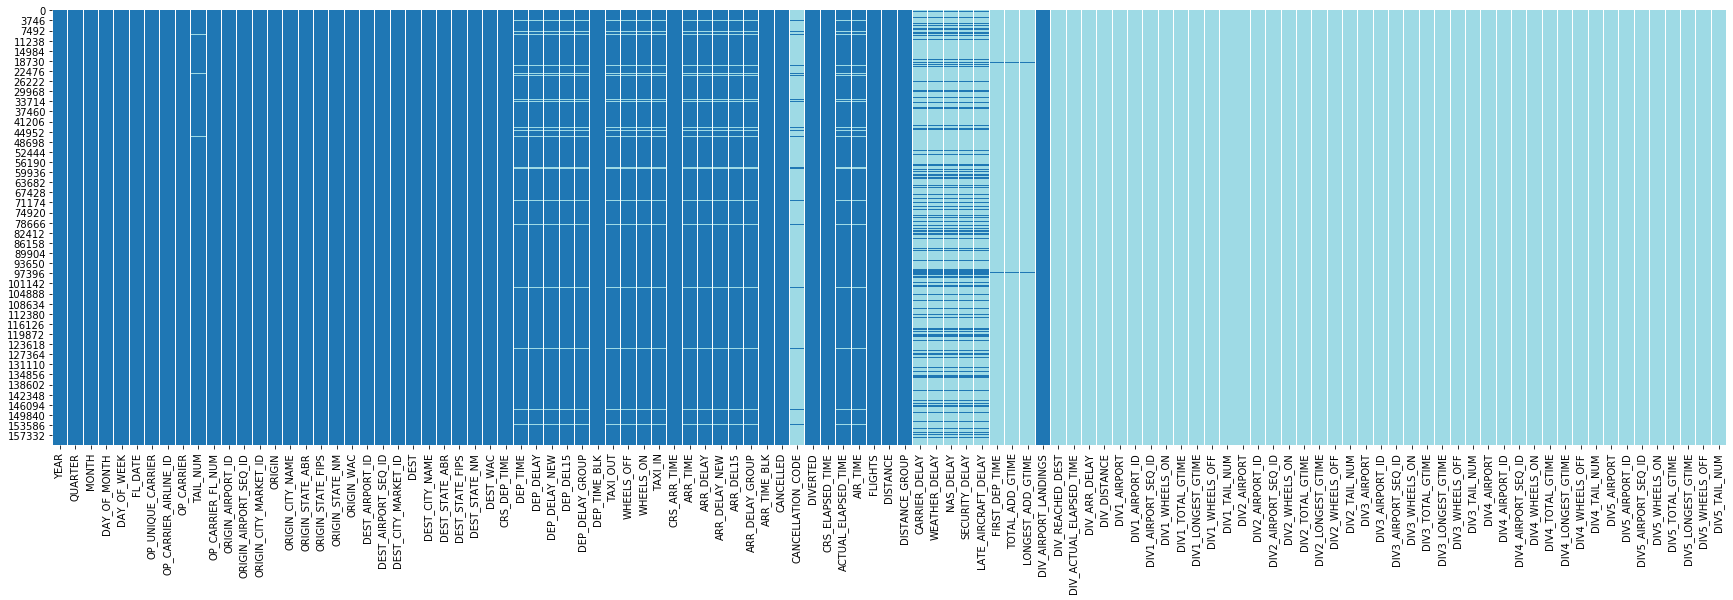

<matplotlib.axes._subplots.AxesSubplot at 0x7f0ea34d2450>

In [0]:
airlines_3m = spark.read.option("header", "true").parquet(f"dbfs:/mnt/mids-w261/datasets_final_project/parquet_airlines_data_3m/part*.parquet");
fig, ax = plt.subplots(figsize=(30,8));
sns.heatmap(airlines_3m.toPandas().isnull(), cmap='tab20', cbar=False);

### Outcome Variable
Since both flight delays and cancellations are costly for passengers and airlines and can benefit from early detection, we created a custom variable within the airline data set to use as our outcome variable. The "Percent of Flights by Departure Status" figure shows approximately 18% of all flights were delayed and 1.5% of the flights were cancelled. We combined these two features into one final outcome variable which makes up around 20% of the total flights data. Due to this imbalance in data (80% not delayed versus 20% delayed), we utilized `class weights` in our model to balance the two classes and is explained in more detail in *Section 4: Algorithm Exploration*.  

The flights data also included a breakdown of the arrival delay minutes into root causes: `Carrier`, `Weather`, `National Aviation System (NAS)`, `Security`, and `Late Aircraft`. The "Percent of Arrival Delay Minutes by Type of Delay" figure below shows the distribution of these delays. We can see the `Late Aircraft` delay had the greatest proportion which persuaded us to create a new feature for previously delayed flights into our dataset as explained in *Section 3: Feature Engineering*. `Carrier` delays were the next most common delay. Including the airline and origin airport in our data should account for variance in processes across airlines and airports that would cause the need for additional time on maintenance, fueling, and baggage loading which are all include in `Carrier` delays \\(^2\\).
Some `National Aviation System` delays include non-extreme weather conditions captured in our weather data and heavy traffic volume which we created features to capture.
Extreme weather only accounted for 5% of delays so we are expecting the weather features we use to be helpful in prediction but potentially not as important as other features.  Finally `Security` delays were very infrequent and therefore, we are not concerned about not having security related variables available for our model.

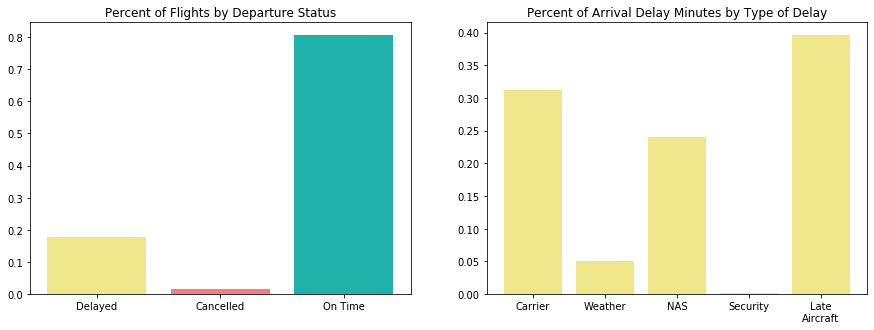

In [0]:
airlines_full.registerTempTable("f");

# extract percent of each flight type
flight_type_df = spark.sql("""SELECT SUM(DEP_DEL15)/COUNT(FLIGHTS) AS DELAY_PCT, SUM(CANCELLED)/COUNT(FLIGHTS) as CANCELLATION_PCT, (COUNT(FLIGHTS)-SUM(DEP_DEL15)-SUM(CANCELLED))/COUNT(FLIGHTS) AS ON_TIME_DEPARTURE_PCT FROM f """).toPandas()
flight_type_df = flight_type_df.T.reset_index()
flight_type_df.columns = ['Type', 'Percent']

# extract delay types
delay_type_df = spark.sql("""SELECT
            sum(CARRIER_DELAY)/(sum(CARRIER_DELAY)+sum(WEATHER_DELAY)+sum(NAS_DELAY)+sum(SECURITY_DELAY)+sum(LATE_AIRCRAFT_DELAY)) AS CARRIER_DELAY_PCT,
            sum(WEATHER_DELAY)/(sum(CARRIER_DELAY)+sum(WEATHER_DELAY)+sum(NAS_DELAY)+sum(SECURITY_DELAY)+sum(LATE_AIRCRAFT_DELAY)) AS WEATHER_DELAY_PCT,
            sum(NAS_DELAY)/(sum(CARRIER_DELAY)+sum(WEATHER_DELAY)+sum(NAS_DELAY)+sum(SECURITY_DELAY)+sum(LATE_AIRCRAFT_DELAY)) AS NAS_DELAY_PCT,
            sum(SECURITY_DELAY)/(sum(CARRIER_DELAY)+sum(WEATHER_DELAY)+sum(NAS_DELAY)+sum(SECURITY_DELAY)+sum(LATE_AIRCRAFT_DELAY)) AS SECURITY_DELAY_PCT,
            sum(LATE_AIRCRAFT_DELAY)/(sum(CARRIER_DELAY)+sum(WEATHER_DELAY)+sum(NAS_DELAY)+sum(SECURITY_DELAY)+sum(LATE_AIRCRAFT_DELAY)) AS LATE_AIRCRAFT_DELAY_PCT
            FROM f""").toPandas();
delay_type_df = delay_type_df.T.reset_index()
delay_type_df.columns = ['Type', 'Percent']

# plot

fig, ax = plt.subplots(1, 2, figsize = (15,5))
ax.flat[0].bar(flight_type_df.Type, flight_type_df.Percent, color=['khaki', 'lightcoral', 'lightseagreen']);
ax.flat[0].set_xticklabels(['Delayed', 'Cancelled', 'On Time']);
ax.flat[0].set_title("Percent of Flights by Departure Status");

ax.flat[1].bar(delay_type_df.Type, delay_type_df.Percent, color=['khaki']);
ax.flat[1].set_xticklabels(['Carrier', 'Weather', 'NAS', 'Security', 'Late\nAircraft']);
ax.flat[1].set_title("Percent of Arrival Delay Minutes by Type of Delay");

### Weather Data Abnormalities
After inspecting the weather data we saw that the data for each feature was actually in string format and contained many different measures within one field. We first parsed this data in order to get it in a more interpretable format. We were then able to graph the distributions of the different weather features. We saw that wind speed, cloud height, and visibility distance did not have normal distributions. This was a challenge that we overcame by binning the data for these features. We used the Beaufort scale of wind speed to determine appropriate wind speed buckets that range from calm to stormy weather. The cloud height and visibility distance each had specific values that represent full sky visibility where the majority of observations were categorized. The numerical value didn't have an interpretable meaning, so we bucketed the full visibility group together and added a group for limited visibility with all lower values, making both features binary. This tranfsformation is discussed further in *Section 3: Feature engineering*.

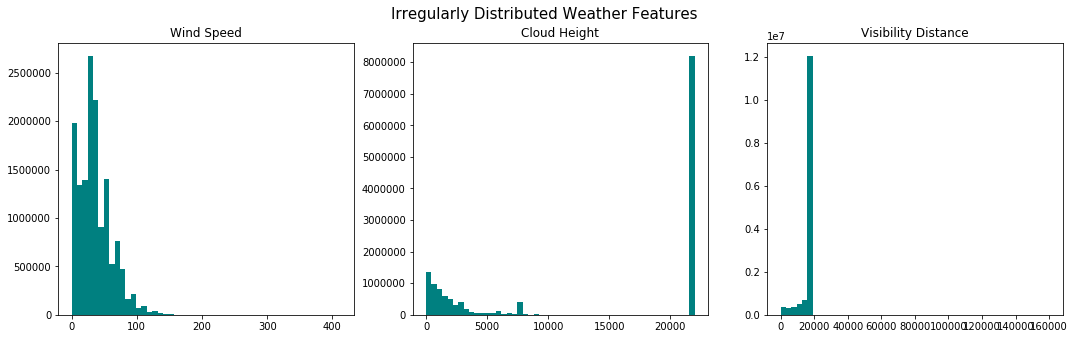

In [0]:
filename = "weather_joined_split"                      #CHANGE THIS: file name in database (to open)
w = spark.read.option("header", "true").parquet("dbfs:/mnt/mids-w261/team_25/weather_processing_folder/"+filename+"/part-00*.parquet")               
w.registerTempTable("w_tt")



w_dropqual = spark.sql("""   SELECT * 
                                FROM w_tt 
                                WHERE 
                                  WND_SPEED_QUAL!='2' and WND_SPEED_QUAL!='3' and WND_SPEED_QUAL!='6' and WND_SPEED_QUAL!='7' and
                                  CIG_QUAL!='2' and CIG_QUAL!='3' and CIG_QUAL!='6' and CIG_QUAL!='7' and
                                  VIS_DIST_QUAL!='2' and VIS_DIST_QUAL!='3' and VIS_DIST_QUAL!='6' and VIS_DIST_QUAL!='7' and
                                  VIS_VAR_QUAL!='2' and VIS_VAR_QUAL!='3' and VIS_VAR_QUAL!='6' and VIS_VAR_QUAL!='7' and
                                  TEMP_QUAL!='2' and TEMP_QUAL!='3' and TEMP_QUAL!='6' and TEMP_QUAL!='7' and
                                  DEW_TEMP_QUAL!='2' and DEW_TEMP_QUAL!='3' and DEW_TEMP_QUAL!='6' and DEW_TEMP_QUAL!='7' and
                                  SLPRESS_QUAL!='2' and SLPRESS_QUAL!='3' and SLPRESS_QUAL!='6' and SLPRESS_QUAL!='7' """)
w_dropqual = w_dropqual.drop('WND_SPEED_QUAL','CIG_QUAL','VIS_DIST_QUAL','VIS_VAR_QUAL','TEMP_QUAL','DEW_TEMP_QUAL','SLPRESS_QUAL')

w_dropqual_dropna = w_dropqual.na.drop()

#REMOVE THOSE WITH 99999,9999,999 missing values and REPORT_TYPE SY-MT or FM-16
w_dropqual_dropna.registerTempTable('missing')
w_dropqual_dropna_drop99999 = spark.sql("""SELECT * 
                                                  FROM missing 
                                                  WHERE 
                                                  WND_SPEED!=9999 and CIG_HEIGHT!=99999 and 
                                                  VIS_DIST!=999999 and VIS_VAR!='9' and 
                                                  TEMP!=9999 and DEW_TEMP!=9999 and SLPRESS!=99999 and
                                                  REPORT_TYPE != 'SY-MT' and REPORT_TYPE != 'FM-16' and
                                                  REPORT_TYPE != 'SOD' and REPORT_TYPE != 'SOM'
                                             """)

w_df=w_dropqual_dropna_drop99999.toPandas()



FIELDS = ['WND_SPEED', 'CIG_HEIGHT', 'VIS_DIST']
titles = ['Wind Speed', 'Cloud Height', 'Visibility Distance']

# part b -  plot boxplots of each feature vs. the outcome
fig, ax_grid = plt.subplots(1, 3, figsize=(18,5))
for idx, feature in enumerate(FIELDS[:]):
    x = w_df[feature]
    ax_grid[idx].hist(x, bins=50, color='teal')
    ax_grid[idx].set_title(f'{titles[idx]}')
fig.suptitle("Irregularly Distributed Weather Features", fontsize=15)
display(plt.show())


### Seasonality
We noticed a recurring theme of seasonality as we explored both the airlines and weather datasets. The plot below shows just one year of daily flight volume compared to average daily flight volume. It is clear from the graph that summer months have a busier schedule and winter is lighter. Holidays tend to see a large drop on the day of the holiday but a spike in flights in the days surrounding it, likely due to people traveling to celebrate. The red and blue indicate above and below average flight delay rates, showing there may be some correlation between flight volume and delays, with many above average delay days occuring in summer.

The weather animations show that it's not just flight volume that changes over the course of a year, but unsurprisingly the weather changes as well. One way we accounted for this seasonality in our model was to split our train, test and validation data by month for our 3 month dataset and by year for our full 5 year dataset. Splitting by time allowed us to ensure that our training data included all seasons. Additionally, we decided to create a "busyness" feature that tracks the volume of flights for each day to hopefully capture this variance in data as well which is discused in *Section 3: Feature engineering*.

Out[18]:

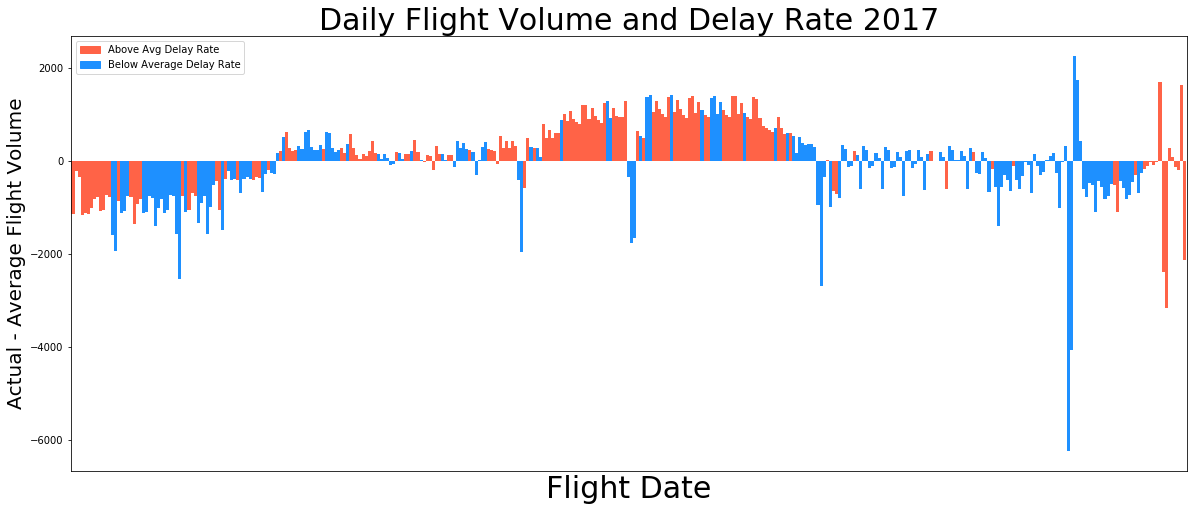

<matplotlib.legend.Legend at 0x7f893d212910>

In [0]:
#read data
days = spark.read.option("header", "true").parquet(f"dbfs:/mnt/mids-w261/datasets_final_project/parquet_airlines_data/20*.parquet").select("OP_UNIQUE_CARRIER", "YEAR", "ORIGIN", "DAY_OF_WEEK", "FL_DATE", "FLIGHTS", "DEP_DEL15")
days.registerTempTable("days_tt")

# calculate average flight volume by airport, airline, year and day of week
spark.sql("SELECT YEAR, OP_UNIQUE_CARRIER, ORIGIN, DAY_OF_WEEK as DAY_OF_WEEK_A, SUM(FLIGHTS)/COUNT(DISTINCT(FL_DATE)) AS FL_PER_DAY FROM days_tt GROUP BY YEAR, OP_UNIQUE_CARRIER, ORIGIN, DAY_OF_WEEK").registerTempTable("avg_days_tt")
# calculate actual flights per day by airport, airline, year and day of week
spark.sql("""SELECT YEAR, OP_UNIQUE_CARRIER as AIRLINE, ORIGIN as AIRPORT, DAY_OF_WEEK, FL_DATE, SUM(FLIGHTS) AS FLIGHTS, SUM(DEP_DEL15) AS DELAYS
                      FROM days_tt
                      GROUP BY YEAR, OP_UNIQUE_CARRIER, ORIGIN, DAY_OF_WEEK, FL_DATE""").registerTempTable("flights_day_tt")
# join average and actual flight volume                     
days_df = spark.sql("SELECT * FROM flights_day_tt JOIN avg_days_tt ON flights_day_tt.YEAR = avg_days_tt.YEAR AND flights_day_tt.AIRLINE = avg_days_tt.OP_UNIQUE_CARRIER AND flights_day_tt.AIRPORT = avg_days_tt.ORIGIN AND flights_day_tt.DAY_OF_WEEK = avg_days_tt.DAY_OF_WEEK_A")
days_df.registerTempTable('days_tt2')


fl_per_day_df_2017 = spark.sql("""SELECT CAST(FL_DATE AS DATE), SUM(FLIGHTS)-SUM(FL_PER_DAY) as DIFFERENCE,
                          IF(SUM(DELAYS)/SUM(FLIGHTS)<.176, 'a', 'b') AS DELAY_PCT_V_AVG,
                          SUM(DELAYS)/SUM(FLIGHTS) as DELAY_PCT
                          FROM days_tt2
                          WHERE YEAR(CAST(FL_DATE AS DATE)) = 2017
                          GROUP BY FL_DATE
                          SORT BY CAST(FL_DATE AS DATE)""").toPandas()

fl_per_day_df_2017.plot.bar(x='FL_DATE', y='DIFFERENCE', width=1.0, color=fl_per_day_df_2017['DELAY_PCT_V_AVG'].map({'a': 'dodgerblue', 'b': 'tomato'}), figsize=(20,8), xticks=[])
plt.title("Daily Flight Volume and Delay Rate 2017", fontsize=30)
plt.xlabel("Flight Date", fontsize=30)
plt.ylabel("Actual - Average Flight Volume", fontsize=20)
# plt.legend(["AAA", "BBB"])

colors = {'Above Avg Delay Rate':'tomato', 'Below Average Delay Rate':'dodgerblue'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)

In [0]:
dbt = spark.sql("""SELECT LATITUDE, LONGITUDE, DATE(CONCAT(YEAR, '-', MONTH, '-', '01')) as FL_MONTH, AVG(TEMP)/10 as AVG_TEMP, 
                AVG(DEW_TEMP)/10 as AVG_DEW_TEMP, AVG(SLPRESS)/10 as AVG_SLPRESS,
                COUNT(LATITUDE) as FLIGHTS
                FROM full_tt
                WHERE YEAR < 2018 and LATITUDE > 24 and LATITUDE <50
                GROUP BY LATITUDE, LONGITUDE, FL_MONTH
                SORT BY FL_MONTH""").toPandas()


# AVERAGE TEMPERATURE
df1 = dbt.pivot_table(index=['LATITUDE', 'LONGITUDE'], columns='FL_MONTH', values = 'AVG_TEMP').fillna(0)
df1.reset_index(drop=False, inplace=True)
df1ts = df1.set_index(["LATITUDE", "LONGITUDE"])

# Data Frame containing volume of flights to use for size
df2 = dbt.pivot_table(index=['LATITUDE', 'LONGITUDE'], columns='FL_MONTH', values = 'FLIGHTS').fillna(0)
df2.reset_index(drop=False, inplace=True)
df2ts = df2.set_index(["LATITUDE", "LONGITUDE"])


#Animation Plot of cases over time

from matplotlib import animation
import datetime

%matplotlib notebook

#Initial plot set-up
fig, axs = plt.subplots(figsize=(18,10))
# plt.xticks(rotation=90, fontsize=10)


#Did not use init function but can be used to set initial background of plot per frame
def init():
    return

#Create function for EACH frame, input to FuncAnimation method
def animate(frameno):
    axs.clear()
    axs.axis('off')
    axs.set_title("Average Air Temperature During "+datetime.date(1900, int(df1ts.iloc[:,frameno].name[5:7]), 1).strftime('%b')+" "+str(df1ts.iloc[:,frameno].name)[0:4], fontsize=40)
    return axs.scatter(df1ts.index.get_level_values('LONGITUDE'), df1ts.index.get_level_values('LATITUDE'),
    c=df1ts.iloc[:,frameno], s=df2ts.iloc[:,frameno]/8, cmap=cmap, norm=norm, alpha=0.9)

cmap = plt.get_cmap("jet")
norm = colors.Normalize(-15, 40)
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs)
cbar.set_label("Degrees Celsius", fontsize=20)
cbar.ax.tick_params(labelsize=20)
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=np.arange(36), interval=500, blit=False)

anim.save('temp.gif', writer='pillow')    #saves the animation to a .gif file


plt.show()    

<img src="https://raw.githubusercontent.com/jaclynandrews/for_w261_final_project/main/temp.gif", width = 700, height = 350><img src="https://raw.githubusercontent.com/jaclynandrews/for_w261_final_project/main/pressure.gif", width = 700, height = 350>

### Delay Propagation

We looked across airports at how the time of day (local time of departure airport) affects delays and found that earlier in the day there are far fewer delays than later in the day. The animation below shows that later on in the day, there is a greater percentage of flights that were delayed.  In this exploration we also found that flights rarely are scheduled to depart before 5am local time. These results led to feature engineering efforts of creating a feature indicating whether the aircraft was delayed on its latest flight of the day, using a binary indicator of first flight of the day and binning the departure times. All are discussed in *Section 3: Feature Engineering*.  
<img src="https://raw.githubusercontent.com/jaclynandrews/for_w261_final_project/main/hourly_delay.gif", width="600" height="40">

# 3. Feature Engineering

In this feature engineering section, the full pipeline from processing raw data into a set of train/validation/test data for machine learning predictions is described, chronologically, step-by-step. The descriptions provided for each step illustrates feature transformations, feature creations, categorical variable treatment, table joins, and imputation of data. While the actual coding is not presented, code snippets are included along with a link to the notebooks that handled each of these feature engineering steps.

### Flights Data Preprocessing 

The following steps were done to pre-process the raw flights data to prepare it for joining with weather data.  

- **Select only columns that will be used for modeling or pre-processing**  
In order to process the large dataset more efficiently, we reduced the size of the dataset to only columns that are relevant for modeling which would help reduce the compute time in all future data processing. Specifically, these were the columns that we chose to keep from the raw dataset: `YEAR`, `MONTH`, `DAY_OF_WEEK`, `FL_DATE`, `OP_UNIQUE_CARRIER`, `ORIGIN`, `ORIGIN_STATE_ABR`, `DEST`, `DEST_STATE_ABR`, `CRS_DEP_TIME`, `CRS_ELAPSED_TIME`, `DISTANCE`  
The temporal features are the `YEAR`, `MONTH`, `DAY_OF_WEEK`, `FL_DATE` (which is for flight date), and `CRS_DEP_TIME` (which is the scheduled departure time of the flight).
The specific airline carrier feature is the `OP_UNIQUE_CARRIER`.  
The geographic features are the `ORIGIN`, `ORIGIN_STATE_ABR`, `DEST`, `DEST_STATE_ABR` which indicate the origin an destination 3-letter airport IATA code) and the state abbreviation.  
Additional information about the flight include the `CRS_ELAPSED_TIME` which indicates the scheduled elapsed time of the total flight and `DISTANCE` (in miles) which is the distance of the trip from origin to destination.   

- **Create feature: FIRST_DEP**  
The next step was to convert the `FIRST_DEP` feature to a binary variable to flag flights that were either the first flight departure at the airport that day or not. 

- **Create outcome: DELAY**  
Also, we created the `DELAY` feature.  As discussed earlier, for the delay outcome variable, we combined the `DEP_DEL15` and `CANCELLED` features which represent the flights delayed by 15 minutes and cancelled flights, respectively. This is because our business problem prediction is based on predicting if a flight was either delayed or cancelled.  
This following code completed the three previous steps:
```
airlines_filter   
= spark.sql("""SELECT YEAR, MONTH, DAY_OF_WEEK, FL_DATE, OP_UNIQUE_CARRIER, TAIL_NUM, ORIGIN, ORIGIN_STATE_ABR, 
                              DEST, DEST_STATE_ABR, CRS_DEP_TIME, DEP_TIME, DEP_DEL15, CANCELLED, CRS_ELAPSED_TIME, DISTANCE,   
                              case when FIRST_DEP_TIME is not null then 1 else 0 end as FIRST_DEP,   
                              case when DEP_DEL15=1 or CANCELLED=1 then 1 else 0 end as DELAY   
                              FROM airlines_sql""")   
```

- **Create column: TimeStamp (for join)**  
Since the airlines data's temporal features were `strings` type instead of `datetime` type and knowing that we would have to join the flights data to weather data on `time`, we created a feature for datetime to make future processes more efficient.    
The following code utilized user-defined-functions and pyspark withColumn code to create the datetime feature:  
```
def concat_datetime(col1,col2):  
  col1, col2 = str(col1), str(col2)  
  if len(col2) < 4:  
    return col1+' 0'+col2[:-2]+':'+ col2[-2:] +':00'    
  else:  
    return col1+' '+col2[:-2]+':'+ col2[-2:] +':00'  
concat_datetime_udf = udf(concat_datetime)  
airlines_3m_filter_dt = airlines_3m_filter.withColumn("CRS_DEP_DATETIME", concat_datetime_udf("FL_DATE","CRS_DEP_TIME"))   
airlines_3m_filter_dt = airlines_3m_filter_dt.withColumn("CRS_DEP_TIME_DT", (f.col("CRS_DEP_DATETIME").cast("timestamp")))    
airlines_3m_filter_dt = airlines_3m_filter_dt.drop("CRS_DEP_DATETIME")   
airlines_3m_filter_dt = airlines_3m_filter_dt.withColumn("DEP_DATETIME", concat_datetime_udf("FL_DATE","DEP_TIME"))  
airlines_3m_filter_dt = airlines_3m_filter_dt.withColumn("DEP_TIME_DT", (f.col("DEP_DATETIME").cast("timestamp")))    
airlines_3m_filter_dt = airlines_3m_filter_dt.drop("DEP_DATETIME")
```   

- **Create column: ICAO codes (for join)**  
Since the raw flights data shows IATA codes for airports while the weather data showed ICAO codes, a conversion from IATA to ICAO provided a key to join data on.  
This code utilized a 3rd-party helper icao_and_icao conversion table to join to both origin and destination airports:  
```
spark.sql("""select t1.*, t2.icao_code as origin_icao_code from(  
          (select * from airlines_trimmed_tt) t1  left join  (select IATA_CODE, ICAO_CODE from iata_and_icao_codes_tt) t2  
          on trim(t1.origin) = t2.iata_code)""").registerTempTable('add_iata_codes_p1')  
spark.sql("""select t1.*, t2.icao_code as dest_icao_code from(  
          (select * from add_iata_codes_p1) t1  left join  (select IATA_CODE, ICAO_CODE from iata_and_icao_codes_tt) t2  
          on trim(t1.dest) = t2.iata_code)""").registerTempTable('airlines_with_icao_tt')  
```

- **Drop x3 Airports / Replace x1**   
After adding the ICAO code for each airport in order to join the airlines data with the weather data, we then checked that every airport in the airlines data had weather readings. Our analysis showed that `57A`, `TJPS`, and `KOGS` did not have weather readings and therefore, were dropped.  Also, the airport with ICAO code `KXWA` was changed to `KISN` at some point in the data and therefore, `KXWA` was replaced with `KISN` to be consistent.

- **Create column: Timezone**  
Another challenge on temporal data is that they are in local airport time. This would make it difficult when eventually joining with the weather data. A conversion to UTC time made future processes more efficient. Using the python "timezonefinder" package, a conversion to UTC time was possible by utilizing the weather data's latitude and longitude to determine a timezone. The timezone is joined to the flights table on the airport IATA code. 
This code took the raw weather data, assigned timezones to each `CALL_SIGN` (IATA codes) and joined it to the flights table:  
```
w = spark.read.option("header", "true").parquet(f"dbfs:/mnt/mids-w261/datasets_final_project/weather_data/*.parquet")  #Read in weather data
call_signs = w.select("CALL_SIGN", "LATITUDE", "LONGITUDE").distinct() #Get all call_signs
from timezonefinder import TimezoneFinder  #Import timezonefinder package to find timezone of each call_sign/latitude/longitude
tf = TimezoneFinder()
cs = call_signs.toPandas()
def tz(row):
  return tf.timezone_at(lng=float(row["LONGITUDE"]), lat=float(row["LATITUDE"]))   #Add timezone of each call_sign
cs["tz"] = cs.apply(lambda row: tz(row), axis=1)
cs = cs[["CALL_SIGN", "tz"]].drop_duplicates()
time_zones = spark.createDataFrame(cs)
time_zones.registerTempTable("time_zones_tt") #Register time_zones table as temp table
spark.sql("select trim(CALL_SIGN) as CALL_SIGN, tz from time_zones_tt").registerTempTable("time_zones_tt_trimmed") #Trim call signs to remove extra spaces
spark.sql("""select t1.*, t2.tz as origin_time_zone
          from(
          (select *
          from updated_dropped_airlines_with_icao_tt) t1
          left join
          (select *
          from time_zones_tt_trimmed) t2
          on t1.origin_icao_code = t2.call_sign)""").registerTempTable("airlines_with_icao_tz_tt"
```

- **Use timezone column to do UTC Time Conversion**  
With the timezone for each flight, the local datetime can then be converted to the UTC datetime shown in the following code:  
```
def convert_to_utc(fl_date, tz_str):
  if fl_date:
    tz = timezone(tz_str)
    fl_date_local = tz.localize(fl_date)
    utc = pytz.utc
    fl_date_utc = fl_date_local.astimezone(utc)
  else:
    fl_date_utc = fl_date
  return fl_date_utc 
convert_to_utc_udf = udf(convert_to_utc, TimestampType())
airlines_with_icao_tz_utc = airlines_with_icao_tz.withColumn("crs_dep_time_utc", convert_to_utc_udf("CRS_DEP_TIME_DT", "origin_time_zone"))
airlines_with_icao_tz_utc = airlines_with_icao_tz_utc.withColumn("dep_time_utc", convert_to_utc_udf("DEP_TIME_DT", "origin_time_zone"))
```

- **Create column: 2&3hrs (for weather join)**  
Further down the data processing pipeline, the 2 hours and 3 hours prior data will be needed to join with the weather data. Therefore, we made these features with the following code:  
```
def subtract2(row):
  return row - timedelta(hours=2)      #Create User-Defined Functions (UDF)  
def subtract3(row):
  return row - timedelta(hours=3)      #Create User-Defined Functions (UDF)  
subtract2_udf = udf(subtract2, TimestampType())       
subtract3_udf = udf(subtract3, TimestampType())  
airlines_with_icao_tz_utc_23 = airlines_with_icao_tz_utc.withColumn("CRS_DEP_TIME_2HR", subtract2_udf("crs_dep_time_utc"))      #Subtract 2 hours with UDF  
airlines_with_icao_tz_utc_23 = airlines_with_icao_tz_utc_23.withColumn("CRS_DEP_TIME_3HR", subtract3_udf("crs_dep_time_utc"))   #Subtract 3 hours with UDF  
airlines_with_icao_tz_utc_23 = airlines_with_icao_tz_utc_23.withColumn("CRS_DEP_TIME_2HR_HR", date_trunc(timestamp='CRS_DEP_TIME_2HR',format='hour')) #Also Create Truncated versions  
airlines_with_icao_tz_utc_23 = airlines_with_icao_tz_utc_23.withColumn("CRS_DEP_TIME_3HR_HR", date_trunc(timestamp='CRS_DEP_TIME_3HR',format='hour')) #Also Create Truncated versions  
```

- **Create column: Truncated Date (for prior flights join)**
Here we created a new feature that indicated the date only of the flight from the datetime column. This is used in the next step.  
```
airlines_with_icao_tz_utc_23 = airlines_with_icao_tz_utc_23.withColumn("CRS_DEP_TIME_DATE_TODAY", date_trunc(timestamp='crs_dep_time_utc',format='day')) #For Prior Flight Delay
airlines_with_icao_tz_utc_23 = airlines_with_icao_tz_utc_23.withColumn("DEP_TIME_DATE_TODAY", date_trunc(timestamp='dep_time_utc',format='day')) #For Prior Flight Delay
```

- **Create feature: Prior_Delay**  
We created a Previously Delayed Flight column indicating if the previous flight had a delayed departure.  From our exploratory data analysis, there were more delayed flights later on in a day which implies delay propagation where if the previous flights of the same plane was delayed, the latter flights are more likely to be delayed.   
The image below explains the strategy which was implemented. Note that in Step 2, the treatment of training and testing data were different.  Training data utilized the `prior_delay` feature which indicates if a previous flight was delayed or not.  However, testing data may not necessarily have this data because testing data would be provided 2 hours prior to flight departure time. The previous flight may not have been delayed yet.  Therefore, testing data compared the actual departure time of the previous flight to the scheduled departure time of the previous flight. If the difference is greater than 15 minutes, indicating a delay in the previous flight, then the previous_flight feature would be marked as `1` for delay. Otherwise, it would be `0` for when either the previous flight was not delayed or when data about the previous flight actual departure time does not exist 2 hours prior to actual flight departure time.  
<img src ="https://raw.githubusercontent.com/CSJohnLee/projects_ucb_mids/master/Images/PriorFlight.PNG", width="1400">

- **Remove irrelevant columns**   
Finally, the rest of the irrelevant columns used for this flights pre-processing were removed.  The final table was stored and would be used for the next phase in the pipeline. 

---   
In the cell below, the pre-processed flights data is shown. 

For the complete flights pre-processing pipeline, please refer to the following notebook:  
  https://dbc-c4580dc0-018b.cloud.databricks.com/?o=8229810859276230#notebook/2158640876508903/command/2158640876508904

In [0]:
#Read Data
filename = "airlines_preprocessed"                      #CHANGE THIS: file name in database (to open)
airlines_preprocessed = spark.read.option("header", "true").parquet("dbfs:/mnt/mids-w261/team_25/data_processing_folder/"+filename+"/part-00*.parquet")
airlines_preprocessed.display()
print("Rows:", airlines_preprocessed.count(), "Columns:", len(airlines_preprocessed.columns))

YEAR MONTH DAY_OF_WEEK FL_DATE OP_UNIQUE_CARRIER ORIGIN ORIGIN_ICAO_CODE ORIGIN_STATE_ABR DEST DEST_ICAO_CODE DEST_STATE_ABR CRS_DEP_TIME CRS_DEP_TIME_UTC CRS_DEP_TIME_2HR CRS_DEP_TIME_3HR CRS_DEP_TIME_2HR_HR CRS_DEP_TIME_3HR_HR CRS_ELAPSED_TIME DISTANCE FIRST_DEP PREVIOUS_DELAY DELAY 2016 4 6 2016-04-30 UA DFW KDFW TX ORD KORD IL 900 2016-04-30T14:00:00.000+0000 2016-04-30T12:00:00.000+0000 2016-04-30T11:00:00.000+0000 2016-04-30T12:00:00.000+0000 2016-04-30T11:00:00.000+0000 142.0 802.0 0 1 1 2016 4 2 2016-04-05 UA EWR KEWR NJ RSW KRSW FL 1521 2016-04-05T19:21:00.000+0000 2016-04-05T17:21:00.000+0000 2016-04-05T16:21:00.000+0000 2016-04-05T17:00:00.000+0000 2016-04-05T16:00:00.000+0000 192.0 1068.0 0 0 0 2016 4 7 2016-04-03 WN DAY KDAY OH MCO KMCO FL 1255 2016-04-03T16:55:00.000+0000 2016-04-03T14:55:00.000+0000 2016-04-03T13:55:00.000+0000 2016-04-03T14:00:00.000+0000 2016-04-03T13:00:00.000+0000 130.0 808.0 0 0 0 2016 4 6 2016-04-02 WN SNA KSNA CA LAS KLAS NV 1555 2016-04-02T22:55:00.000+0000 2016-04-02T20:55:00.000+0000 2016-04-02T19:55:00.000+0000 2016-04-02T20:00:00.000+0000 2016-04-02T19:00:00.000+0000 60.0 226.0 0 0 0 2016 4 4 2016-04-07 WN LAX KLAX CA OAK KOAK CA 1545 2016-04-07T22:45:00.000+0000 2016-04-07T20:45:00.000+0000 2016-04-07T19:45:00.000+0000 2016-04-07T20:00:00.000+0000 2016-04-07T19:00:00.000+0000 75.0 337.0 0 0 0 2016 4 1 2016-04-18 EV AGS KAGS GA ATL KATL GA 1035 2016-04-18T14:35:00.000+0000 2016-04-18T12:35:00.000+0000 2016-04-18T11:35:00.000+0000 2016-04-18T12:00:00.000+0000 2016-04-18T11:00:00.000+0000 60.0 143.0 0 0 0 2016 4 2 2016-04-05 OO IDA KIDA ID SLC KSLC UT 749 2016-04-05T13:49:00.000+0000 2016-04-05T11:49:00.000+0000 2016-04-05T10:49:00.000+0000 2016-04-05T11:00:00.000+0000 2016-04-05T10:00:00.000+0000 63.0 188.0 0 0 0 2015 9 5 2015-09-04 EV IAH KIAH TX STL KSTL MO 1254 2015-09-04T17:54:00.000+0000 2015-09-04T15:54:00.000+0000 2015-09-04T14:54:00.000+0000 2015-09-04T15:00:00.000+0000 2015-09-04T14:00:00.000+0000 126.0 667.0 0 0 0 2015 9 2 2015-09-08 WN PBI KPBI FL BWI KBWI MD 1355 2015-09-08T17:55:00.000+0000 2015-09-08T15:55:00.000+0000 2015-09-08T14:55:00.000+0000 2015-09-08T15:00:00.000+0000 2015-09-08T14:00:00.000+0000 140.0 883.0 0 0 0 2015 9 2 2015-09-08 WN SAT KSAT TX LAS KLAS NV 550 2015-09-08T10:50:00.000+0000 2015-09-08T08:50:00.000+0000 2015-09-08T07:50:00.000+0000 2015-09-08T08:00:00.000+0000 2015-09-08T07:00:00.000+0000 170.0 1069.0 0 0 0 2019 7 5 2019-07-26 WN RDU KRDU NC ATL KATL GA 1100 2019-07-26T15:00:00.000+0000 2019-07-26T13:00:00.000+0000 2019-07-26T12:00:00.000+0000 2019-07-26T13:00:00.000+0000 2019-07-26T12:00:00.000+0000 80.0 356.0 0 0 0 2019 7 3 2019-07-03 AA SFO KSFO CA CLT KCLT NC 1323 2019-07-03T20:23:00.000+0000 2019-07-03T18:23:00.000+0000 2019-07-03T17:23:00.000+0000 2019-07-03T18:00:00.000+0000 2019-07-03T17:00:00.000+0000 316.0 2296.0 0 0 0 2019 6 3 2019-06-12 AA PHX KPHX AZ SLC KSLC UT 1003 2019-06-12T17:03:00.000+0000 2019-06-12T15:03:00.000+0000 2019-06-12T14:03:00.000+0000 2019-06-12T15:00:00.000+0000 2019-06-12T14:00:00.000+0000 105.0 507.0 0 0 0 2019 5 2 2019-05-28 YV PHX KPHX AZ DRO KDRO CO 1610 2019-05-28T23:10:00.000+0000 2019-05-28T21:10:00.000+0000 2019-05-28T20:10:00.000+0000 2019-05-28T21:00:00.000+0000 2019-05-28T20:00:00.000+0000 72.0 353.0 0 0 0 2019 5 4 2019-05-09 AA PHL KPHL PA PHX KPHX AZ 1540 2019-05-09T19:40:00.000+0000 2019-05-09T17:40:00.000+0000 2019-05-09T16:40:00.000+0000 2019-05-09T17:00:00.000+0000 2019-05-09T16:00:00.000+0000 315.0 2075.0 0 0 1 2019 5 4 2019-05-23 HA HNL PHNL HI SAN KSAN CA 1350 2019-05-23T23:50:00.000+0000 2019-05-23T21:50:00.000+0000 2019-05-23T20:50:00.000+0000 2019-05-23T21:00:00.000+0000 2019-05-23T20:00:00.000+0000 325.0 2614.0 0 0 0 2019 5 5 2019-05-17 HA LIH PHLI HI LAX KLAX CA 1250 2019-05-17T22:50:00.000+0000 2019-05-17T20:50:00.000+0000 2019-05-17T19:50:00.000+0000 2019-05-17T20:00:00.000+0000 2019-05-17T19:00:00.000+0000 340.0 2615.0 0 0 0 2016 8 6 2016-08-20 AA BOS KBOS MA DCA KDCA VA 1200 2016-08-20

Rows: 31737432 Columns: 22

### Weather Data Preprocessing  

The following steps were done to pre-process the raw weather data to prepare it for joining with flights data. 

- **Select Columns**  
Similar to the flights data, we reduced the size of the weather dataset to only columns that are relevant for modeling which would help reduce the compute time in all future data processing. Specifically, these were the columns that we chose to keep from the raw dataset: `DATE`, `LATITUDE`, `LONGITUDE`, `ELEVATION`, `REPORT_TYPE`, `CALL_SIGN`, `WND`, `CIG`, `VIS`, `TMP`, `DEW`, `SLP`  
The `DATE` feature is of `datetime` type and signifies the datetime of the weather reading.  
Geographic features included `LATITUDE`, `LONGITUDE`, and `ELEVATION`.  Additionally, the `CALL_SIGN` feature is the ICAO code of an airport.   
The following are data regarding weather readings:  
`REPORT_TYPE` is the type of weather reading such as reading reported every 15 minutes, every day or every month for example.  
`WND` indicated wind features such as wind speed.  
`CIG` indicated sky-condition.  
`VIS` indicated visibility distance.  
`TMP` and `DEW` indicated the temperature and the dew-point temperature.  
`SLP` indicated the sea level pressure.   

- **Filter Weather Data**  
To further reduce the dataset, only 368 distinct airports (from cleaned flight data) were kept (rest were dropped). This was done by inner joining distinct airports table with weather's `CALL_SIGN`.

- **Parse certain columns**  
The weather data columns have consistent (non-null) data but have many different measures within one field. These include the wind, sky-condition, visibility, temperature, and sea level pressure features. The condensed format of these columns required parsing out.    
This sample code shows the parsing of the wind feature:  
```
split_col = f.split(weather_split['WND'], ',')  
weather_split = weather_split.withColumn('WND_SPEED', split_col.getItem(3).cast(IntegerType()))  
weather_split = weather_split.withColumn('WND_SPEED_QUAL', split_col.getItem(4))  
```  
Once parsed, some weather fields like temperature and sea level pressure have relatively normal distributions but others have odd distributions that require significant transformations or binning. Binning is further discussed later on in this section.  

---   
In the cell below, the pre-processed weather data is shown.   

For the complete weather pre-processing pipeline, please refer to the following notebook:  
https://dbc-c4580dc0-018b.cloud.databricks.com/?o=8229810859276230#notebook/2158640876507578/command/2158640876507579

In [0]:
#Read Data
filename = "weather_joined_split"                      #CHANGE THIS: file name in database (to open)
weather_joined_split = spark.read.option("header", "true").parquet("dbfs:/mnt/mids-w261/team_25/weather_processing_folder/"+filename+"/part-00*.parquet")
weather_joined_split.display()
print("Rows:", weather_joined_split.count(), "Columns:", len(weather_joined_split.columns))

DATE DATE_HR LATITUDE LONGITUDE ELEVATION REPORT_TYPE CALL_SIGN WND_SPEED WND_SPEED_QUAL CIG_HEIGHT CIG_QUAL VIS_DIST VIS_DIST_QUAL VIS_VAR VIS_VAR_QUAL TEMP TEMP_QUAL DEW_TEMP DEW_TEMP_QUAL SLPRESS SLPRESS_QUAL 2019-01-01T00:53:00.000+0000 2019-01-01T00:00:00.000+0000 29.3784 -100.927 304.5 FM-15 KDRT 0 5 22000 5 16093 5 N 5 111 5 17 5 10139 5 2019-01-01T01:53:00.000+0000 2019-01-01T01:00:00.000+0000 29.3784 -100.927 304.5 FM-15 KDRT 0 5 22000 5 14484 5 N 5 106 5 17 5 10144 5 2019-01-01T02:53:00.000+0000 2019-01-01T02:00:00.000+0000 29.3784 -100.927 304.5 FM-15 KDRT 0 5 22000 5 14484 5 N 5 78 5 17 5 10149 5 2019-01-01T03:53:00.000+0000 2019-01-01T03:00:00.000+0000 29.3784 -100.927 304.5 FM-15 KDRT 15 5 22000 5 14484 5 N 5 67 5 11 5 10151 5 2019-01-01T04:53:00.000+0000 2019-01-01T04:00:00.000+0000 29.3784 -100.927 304.5 FM-15 KDRT 31 5 22000 5 16093 5 N 5 72 5 6 5 10154 5 2019-01-01T05:53:00.000+0000 2019-01-01T05:00:00.000+0000 29.3784 -100.927 304.5 FM-15 KDRT 41 5 22000 5 16093 5 N 5 67 5 11 5 10155 5 2019-01-01T05:59:00.000+0000 2019-01-01T05:00:00.000+0000 29.3784 -100.927 304.5 SOD KDRT 9999 9 99999 9 999999 9 9 9 9999 9 9999 9 99999 9 2019-01-01T05:59:00.000+0000 2019-01-01T05:00:00.000+0000 29.3784 -100.927 304.5 SOM KDRT 9999 9 99999 9 999999 9 9 9 9999 9 9999 9 99999 9 2019-01-01T06:53:00.000+0000 2019-01-01T06:00:00.000+0000 29.3784 -100.927 304.5 FM-15 KDRT 36 5 22000 5 16093 5 N 5 61 5 28 5 10156 5 2019-01-01T07:53:00.000+0000 2019-01-01T07:00:00.000+0000 29.3784 -100.927 304.5 FM-15 KDRT 36 5 22000 5 16093 5 N 5 56 5 28 5 10163 5 2019-01-01T08:53:00.000+0000 2019-01-01T08:00:00.000+0000 29.3784 -100.927 304.5 FM-15 KDRT 46 5 22000 5 16093 5 N 5 61 5 28 5 10164 5 2019-01-01T09:53:00.000+0000 2019-01-01T09:00:00.000+0000 29.3784 -100.927 304.5 FM-15 KDRT 41 5 22000 5 16093 5 N 5 67 5 28 5 10162 5 2019-01-01T10:53:00.000+0000 2019-01-01T10:00:00.000+0000 29.3784 -100.927 304.5 FM-15 KDRT 36 5 22000 5 16093 5 N 5 61 5 28 5 10163 5 2019-01-01T11:53:00.000+0000 2019-01-01T11:00:00.000+0000 29.3784 -100.927 304.5 FM-15 KDRT 0 5 22000 5 16093 5 N 5 33 5 17 5 10167 5 2019-01-01T12:53:00.000+0000 2019-01-01T12:00:00.000+0000 29.3784 -100.927 304.5 FM-15 KDRT 0 5 22000 5 16093 5 N 5 22 5 11 5 10183 5 2019-01-01T13:53:00.000+0000 2019-01-01T13:00:00.000+0000 29.3784 -100.927 304.5 FM-15 KDRT 0 5 22000 5 11265 5 N 5 22 5 17 5 10201 5 2019-01-01T14:53:00.000+0000 2019-01-01T14:00:00.000+0000 29.3784 -100.927 304.5 FM-15 KDRT 15 5 22000 5 12875 5 N 5 33 5 28 5 10211 5 2019-01-01T15:53:00.000+0000 2019-01-01T15:00:00.000+0000 29.3784 -100.927 304.5 FM-15 KDRT 0 5 22000 5 16093 5 N 5 61 5 33 5 10222 5 2019-01-01T16:53:00.000+0000 2019-01-01T16:00:00.000+0000 29.3784 -100.927 304.5 FM-15 KDRT 21 5 22000 5 16093 5 N 5 89 5 28 5 10226 5 2019-01-01T17:53:00.000+0000 2019-01-01T17:00:00.000+0000 29.3784 -100.927 304.5 FM-15 KDRT 26 5 22000 5 16093 5 N 5 94 5 33 5 10219 5 2019-01-01T18:53:00.000+0000 2019-01-01T18:00:00.000+0000 29.3784 -100.927 304.5 FM-15 KDRT 46 5 22000 5 16093 5 N 5 89 5 33 5 10210 5 2019-01-01T19:53:00.000+0000 2019-01-01T19:00:00.000+0000 29.3784 -100.927 304.5 FM-15 KDRT 41 5 1829 5 16093 5 N 5 106 5 39 5 10199 5 2019-01-01T20:53:00.000+0000 2019-01-01T20:00:00.000+0000 29.3784 -100.927 304.5 FM-15 KDRT 36 5 1676 5 16093 5 N 5 106 5 39 5 10199 5 2019-01-01T21:53:00.000+0000 2019-01-01T21:00:00.000+0000 29.3784 -100.927 304.5 FM-15 KDRT 31 5 1524 5 16093 5 N 5 106 5 39 5 10194 5 2019-01-01T22:53:00.000+0000 2019-01-01T22:00:00.000+0000 29.3784 -100.927 304.5 FM-15 KDRT 41 5 1402 5 16093 5 N 5 106 5 39 5 10203 5 2019-01-01T23:53:00.000+0000 2019-01-01T23:00:00.000+0000 29.3784 -100.927 304.5 FM-15 KDRT 36 5 1341 5 16093 5 N 5 89 5 33 5 10207 5 2019-01-02T00:53:00.000+0000 2019-01-02T00:00:00.000+0000 29.3784 -100.927 304.5 FM-15 KDRT 51 5 1433 5 16093 5 N 5 78 5 28 5 10220 5 2019-01-02T01:53:00.000+0000 2019-01-02T01:00:00.000+0000 29.3784 -100.927 304.5 FM-15 KDRT 36 5 1463 5 16093 5 N 5 72 5 28 5 10224 5 2019-01

Rows: 22283287 Columns: 21

### Joining of Flights and Weather Data: 

The following steps were done to join the flights and weather data. Note that at this phase, both the flights and weather data have been pre-processed.  

- **Add Unique ID for Flights & Weather Dataset**  
A unique ID was added for each row of flights and weather data with the code below:  
```
air = air_full.coalesce(1)                                   
air = air.withColumn("ID",f.monotonically_increasing_id())   #adds unique ID column
weather = w.coalesce(1)                                                     #Not 100% what this does yet
weather = weather.withColumn("READING_ID",f.monotonically_increasing_id())    #adds unique ID column
```
This was helpful when joining the weather data to the flights data.  

- **Join Origin and Destination Airport Weather**  
The joining of 20-million+ weather data reported every 15, 20, 30, or 60 minutes to 30-million+ flights data had both temporal and computational challenges. The temporal challenge was that the usable weather data would only be available 2 hours prior to actual flight data. The computational challenges was that many "if-else" conditions in coding would require a significant amount of computational resources.  Taking these challenges into consideration, the 4-step solution described in the image below was applied to both `ORIGIN` and `DESTINATION` airports (separately) for each flight.  
<img src ="https://raw.githubusercontent.com/CSJohnLee/projects_ucb_mids/master/Images/W261-WeatherJoin.png">

- **Join ORIGIN and DEST tables on flights (result = 1 table of flights, origin weather, and destination weather)**   
After the joins were created, there would be two tables. One table with flights data and origin airport weather. The second table with identical flights data but with destination airport weather. A final inner join after creating the `ORIGIN` and `DESTINATION` completes the joining step of this data-processing pipeline.  Code snippet provided below:  
```
joined_filtered_agg_o.registerTempTable("joined_filtered_agg_o_tt")
joined_filtered_agg_d.registerTempTable("joined_filtered_agg_d_tt")
joined_filtered_agg = spark.sql("""SELECT t1.*, t2.DEST_DATE, t2.DEST_DATE_HR, t2.DEST_LATITUDE, t2.DEST_LONGITUDE, t2.DEST_ELEVATION, 
                     t2.DEST_REPORT_TYPE, t2.DEST_CALL_SIGN, t2.DEST_WND_SPEED, t2.DEST_WND_SPEED_QUAL, 
                     t2.DEST_CIG_HEIGHT, t2.DEST_CIG_QUAL, t2.DEST_VIS_DIST, t2.DEST_VIS_DIST_QUAL, t2.DEST_VIS_VAR, 
                     t2.DEST_VIS_VAR_QUAL, t2.DEST_TEMP, t2.DEST_TEMP_QUAL, t2.DEST_DEW_TEMP, t2.DEST_DEW_TEMP_QUAL, 
                     t2.DEST_SLPRESS, t2.DEST_SLPRESS_QUAL, t2.DEST_READING_ID, t2.DEST_AIRPORT                      
                                FROM joined_filtered_agg_o_tt t1
                                INNER JOIN joined_filtered_agg_d_tt t2
                                ON (t1.YEAR = t2.YEAR AND
                                    t1.MONTH = t2.MONTH AND
                                    t1.FL_DATE = t2.FL_DATE AND
                                    t1.OP_UNIQUE_CARRIER = t2.OP_UNIQUE_CARRIER AND
                                    t1.ORIGIN = t2.ORIGIN AND
                                    t1.DEST = t2.DEST AND
                                    t1.CRS_DEP_TIME = t2.CRS_DEP_TIME)
                                """)
```

- **Add Busyness of Day (Create helper table, groupby flight date to get count per date, Join helper table to final table)**  
We created a Total Flights Per Day as a measure of the busyness of the day. The idea is that certain days of the year may have more flights while airports still have a finite capacity leading to a higher possiblity of delay. This was implemented by grouping by the flight date and getting a count per date.  **NOTE:** We assumed that the test data in real life would include a full day's worth of scheduled flights and therefore, we can calculate the Total Flights count to use as a feature for the test data.  
Here is the code for creating the helper table:  
```
busyness = joined_filtered_agg.groupBy("FL_DATE").count()
busyness = busyness.withColumnRenamed("FL_DATE", "flight_date") 
busyness = busyness.withColumnRenamed("count", "flights_per_day") 
```
Here is the code to join helper table to flights table: 
```
busyness.registerTempTable("busyness_tt")
joined_filtered_agg.registerTempTable("joined_filtered_agg_tt")
joined_filtered_agg_busy = spark.sql("""SELECT t1.*, t2.flights_per_day
                                FROM joined_filtered_agg_tt t1
                                INNER JOIN busyness_tt t2
                                ON (t1.FL_DATE = t2.flight_date)
                                """)
```

- **Remove irrelevant columns**  
Finally, we remove irrelevant columns.  


---

In the cell below, the joined flights and weather data is shown. Note that it includes a few feature engineering efforts as well which is dicussed later on in this section.  

For the complete flight and weather join pipeline, please refer to the following notebook:  
https://dbc-c4580dc0-018b.cloud.databricks.com/?o=8229810859276230#notebook/2158640876511106

In [0]:
#Read Data
filename = "flight_weather_data"                      
flight_weather_joined = spark.read.option("header", "true").parquet("dbfs:/mnt/mids-w261/team_25/join_data_folder/"+filename+"/part-00*.parquet")
flight_weather_joined.display()
print("Rows:", flight_weather_joined.count(), "Columns:", len(flight_weather_joined.columns))

YEAR MONTH DAY_OF_WEEK OP_UNIQUE_CARRIER ORIGIN ORIGIN_STATE_ABR DEST DEST_STATE_ABR CRS_DEP_TIME CRS_ELAPSED_TIME DISTANCE FIRST_DEP PREVIOUS_DELAY DELAY LATITUDE LONGITUDE ELEVATION REPORT_TYPE WND_SPEED WND_SPEED_QUAL CIG_HEIGHT CIG_QUAL VIS_DIST VIS_DIST_QUAL VIS_VAR VIS_VAR_QUAL TEMP TEMP_QUAL DEW_TEMP DEW_TEMP_QUAL SLPRESS SLPRESS_QUAL DEST_LATITUDE DEST_LONGITUDE DEST_ELEVATION DEST_REPORT_TYPE DEST_WND_SPEED DEST_WND_SPEED_QUAL DEST_CIG_HEIGHT DEST_CIG_QUAL DEST_VIS_DIST DEST_VIS_DIST_QUAL DEST_VIS_VAR DEST_VIS_VAR_QUAL DEST_TEMP DEST_TEMP_QUAL DEST_DEW_TEMP DEST_DEW_TEMP_QUAL DEST_SLPRESS DEST_SLPRESS_QUAL FLIGHTS_PER_DAY 2015 5 5 AA DFW TX AUS TX 2020 67.0 190.0 0 0 0 32.8978 -97.0189 170.7 FM-15 26 5 22000 5 16093 5 N 5 244 5 122 5 10152 5 30.1831 -97.6799 146.3 FM-15 31 5 22000 5 16093 5 N 5 267 5 111 5 10153 5 16927 2015 5 5 AA DFW TX ORD IL 700 146.0 802.0 0 0 0 32.8978 -97.0189 170.7 FM-15 36 5 22000 5 16093 5 N 5 161 5 106 5 10152 5 41.995 -87.9336 201.8 FM-15 26 5 22000 5 16093 5 N 5 33 5 11 5 10203 5 16927 2015 5 5 AA DFW TX SFO CA 905 233.0 1464.0 0 0 0 32.8978 -97.0189 170.7 FM-15 0 5 22000 5 16093 5 N 5 133 5 100 5 10165 5 37.6197 -122.3647 2.4 FM-15 26 5 22000 5 16093 5 N 5 144 5 89 5 10092 5 16927 2015 5 5 AA JFK NY BOS MA 1629 80.0 187.0 0 0 0 40.6386 -73.7622 3.4 FM-15 57 5 1097 5 16093 5 N 5 117 5 44 5 10154 5 42.3606 -71.0097 3.7 FM-15 57 5 7620 5 16093 5 N 5 89 5 39 5 10162 5 16927 2015 5 5 AA LAX CA LAS NV 1640 70.0 236.0 0 0 0 33.938 -118.3888 29.6 FM-15 57 5 5486 5 14484 5 N 5 194 5 128 5 10125 5 36.0719 -115.1634 664.5 FM-15 77 5 7620 5 16093 5 N 5 344 5 -61 5 10071 5 16927 2015 5 5 AA LGA NY MIA FL 1950 189.0 1096.0 0 0 0 40.7792 -73.88 3.4 FM-15 51 5 7620 5 16093 5 N 5 133 5 44 5 10136 5 25.7881 -80.3169 8.8 FM-15 41 5 22000 5 16093 5 N 5 289 5 94 5 10111 5 16927 2015 5 5 AA MCO FL ORD IL 1928 175.0 1005.0 0 0 0 28.4339 -81.325 27.4 FM-15 62 5 22000 5 16093 5 N 5 283 5 106 5 10109 5 41.995 -87.9336 201.8 FM-15 41 5 7620 5 16093 5 N 5 178 5 44 5 10193 5 16927 2015 5 5 AA ORD IL DFW TX 1325 154.0 802.0 0 1 1 41.995 -87.9336 201.8 FM-15 21 5 22000 5 16093 5 N 5 150 5 39 5 10221 5 32.8978 -97.0189 170.7 FM-15 46 5 22000 5 16093 5 N 5 228 5 139 5 10184 5 16927 2015 5 5 AA ORD IL DFW TX 900 163.0 802.0 0 0 0 41.995 -87.9336 201.8 FM-15 31 5 22000 5 16093 5 N 5 67 5 28 5 10214 5 32.8978 -97.0189 170.7 FM-15 0 5 22000 5 16093 5 N 5 133 5 100 5 10165 5 16927 2015 5 5 AS JNU AK ANC AK 1945 96.0 571.0 0 0 0 58.3566 -134.564 4.9 FM-15 57 5 1676 5 16093 5 N 5 94 5 50 5 10155 5 61.169 -150.0278 36.6 FM-15 31 5 7620 5 16093 5 N 5 122 5 6 5 10137 5 16927 2015 5 5 AS ORD IL SEA WA 800 267.0 1721.0 0 0 0 41.995 -87.9336 201.8 FM-15 26 5 22000 5 16093 5 N 5 33 5 17 5 10208 5 47.4444 -122.3138 112.8 FM-15 31 5 6096 5 16093 5 N 5 94 5 61 5 10193 5 16927 2015 5 5 AS SAN CA BOS MA 845 343.0 2588.0 0 0 0 32.7336 -117.1831 4.6 FM-15 0 5 7620 5 14484 5 N 5 172 5 144 5 10111 5 42.3606 -71.0097 3.7 FM-15 15 5 701 5 16093 5 N 5 78 5 44 5 10163 5 16927 2015 5 5 AS SEA WA SNA CA 1400 157.0 978.0 0 0 1 47.4444 -122.3138 112.8 FM-15 36 5 22000 5 16093 5 N 5 156 5 83 5 10189 5 33.68 -117.86639 16.5 FM-15 26 5 7620 5 16093 5 N 5 256 5 111 5 10122 5 16927 2015 5 5 B6 BOS MA EWR NJ 630 83.0 200.0 0 0 0 42.3606 -71.0097 3.7 FM-16 41 5 579 5 16093 5 N 5 70 5 30 5 99999 9 40.6825 -74.1694 2.1 FM-15 36 5 1829 5 16093 5 N 5 100 5 39 5 10132 5 16927 2015 5 5 B6 BOS MA SJU PR 2359 231.0 1674.0 0 0 0 42.3606 -71.0097 3.7 FM-15 31 5 22000 5 16093 5 N 5 56 5 33 5 10164 5 18.4325 -66.01083 2.7 FM-15 21 5 22000 5 16093 5 N 5 278 5 217 5 10150 5 16927 2015 5 5 B6 JFK NY ORD IL 1930 185.0 740.0 0 0 0 40.6386 -73.7622 3.4 FM-15 62 5 7620 5 16093 5 N 5 111 5 44 5 10146 5 41.995 -87.9336 201.8 FM-15 41 5 7620 5 16093 5 N 5 178 5 44 5 10193 5 16927 2015 5 5 DL ATL GA LAS NV 2146 269.0 1747.0 0 0 0 33.6301 -84.4418 307.8 FM-15 57 5 22000 5 16093 5 N 5 206 5 50 5 10150 5 36.0719 -115.1634 664.5 FM-15 93 5 7620 5 16093 5 N 5 344 5 -56 5 10055 5 16927

Rows: 31534960 Columns: 51

### Data Split - Training Data: 

After we've processed a set of data, we split the data to train, validation, and test sets. The train data is used exclusively to train the machine learning models. The validation data is used to tune the machine learning models by measuring the performance of a trained model on a this separate set of data. The test data is the final heldout set of data used at the very end to measure the performance of the final, fully tuned model.  

The split points of the data must avoid data-leakage which can occur if there is shared information between the train data and the validation/test data resulting in an unreliable model when used to predict truely unseen data. Therefore, we selected to split the dataset based on time because we do not believe flights that occur the next day would be related to flights that occured the on the previous day. With the 3-month ('a small world') dataset, the training data were flights that occurred in January and February of 2015 while the validation data were flights that occured in March of 2015 (note that we did not include a test set in the 3-month dataset because we did not feel it was necessary since our full model would be measured on the full-data test set). With the full dataset, the training data were flights that occurred in 2015 through 2017. The validation data were flights that occurred in 2018 and the test data were flights that occured in 2019.  

In this section, the steps to prepare the training data is discussed.  

- **Drop rows**  
In the training dataset, we dropped flights that had nulls or were missing data (shown as `9` or `9999` or `99999` in the raw data depending on the feature). We also dropped suspect or erroneous data and where the weather report types were `sy-mt`, `fm-16`, `sod`, or `som`. These flights were dropped because we believed that unreliable data would force the machine learning models to capture noise in the data which may not actually reflect any relationship to the outcome variable.  
Below is a query to drop these data:  
```
train_dropqual = spark.sql("""   SELECT * 
                                FROM quality 
                                WHERE 
                                  WND_SPEED_QUAL!='2' and WND_SPEED_QUAL!='3' and WND_SPEED_QUAL!='6' and WND_SPEED_QUAL!='7' and
                                  CIG_QUAL!='2' and CIG_QUAL!='3' and CIG_QUAL!='6' and CIG_QUAL!='7' and
                                  VIS_DIST_QUAL!='2' and VIS_DIST_QUAL!='3' and VIS_DIST_QUAL!='6' and VIS_DIST_QUAL!='7' and
                                  VIS_VAR_QUAL!='2' and VIS_VAR_QUAL!='3' and VIS_VAR_QUAL!='6' and VIS_VAR_QUAL!='7' and
                                  TEMP_QUAL!='2' and TEMP_QUAL!='3' and TEMP_QUAL!='6' and TEMP_QUAL!='7' and
                                  DEW_TEMP_QUAL!='2' and DEW_TEMP_QUAL!='3' and DEW_TEMP_QUAL!='6' and DEW_TEMP_QUAL!='7' and
                                  SLPRESS_QUAL!='2' and SLPRESS_QUAL!='3' and SLPRESS_QUAL!='6' and SLPRESS_QUAL!='7' and
                                  DEST_WND_SPEED_QUAL!='2' and DEST_WND_SPEED_QUAL!='3' and DEST_WND_SPEED_QUAL!='6' and DEST_WND_SPEED_QUAL!='7' and
                                  DEST_CIG_QUAL!='2' and DEST_CIG_QUAL!='3' and DEST_CIG_QUAL!='6' and DEST_CIG_QUAL!='7' and
                                  DEST_VIS_DIST_QUAL!='2' and DEST_VIS_DIST_QUAL!='3' and DEST_VIS_DIST_QUAL!='6' and DEST_VIS_DIST_QUAL!='7' and
                                  DEST_VIS_VAR_QUAL!='2' and DEST_VIS_VAR_QUAL!='3' and DEST_VIS_VAR_QUAL!='6' and DEST_VIS_VAR_QUAL!='7' and
                                  DEST_TEMP_QUAL!='2' and DEST_TEMP_QUAL!='3' and DEST_TEMP_QUAL!='6' and DEST_TEMP_QUAL!='7' and
                                  DEST_DEW_TEMP_QUAL!='2' and DEST_DEW_TEMP_QUAL!='3' and DEST_DEW_TEMP_QUAL!='6' and DEST_DEW_TEMP_QUAL!='7' and
                                  DEST_SLPRESS_QUAL!='2' and DEST_SLPRESS_QUAL!='3' and DEST_SLPRESS_QUAL!='6' and DEST_SLPRESS_QUAL!='7'
                                  """)
train_dropqual_dropna = train_dropqual.na.drop()
train_dropqual_dropna.registerTempTable('missing')
train_dropqual_dropna_drop99999 = spark.sql("""SELECT * 
                                                  FROM missing 
                                                  WHERE 
                                                  WND_SPEED!=9999 and CIG_HEIGHT!=99999 and 
                                                  VIS_DIST!=999999 and VIS_VAR!='9' and 
                                                  TEMP!=9999 and DEW_TEMP!=9999 and SLPRESS!=99999 and
                                                  REPORT_TYPE != 'SY-MT' and REPORT_TYPE != 'FM-16' and
                                                  REPORT_TYPE != 'SOD' and REPORT_TYPE != 'SOM' and
                                                  DEST_WND_SPEED!=9999 and DEST_CIG_HEIGHT!=99999 and 
                                                  DEST_VIS_DIST!=999999 and DEST_VIS_VAR!='9' and 
                                                  DEST_TEMP!=9999 and DEST_DEW_TEMP!=9999 and DEST_SLPRESS!=99999 and
                                                  DEST_REPORT_TYPE != 'SY-MT' and DEST_REPORT_TYPE != 'FM-16' and
                                                  DEST_REPORT_TYPE != 'SOD' and DEST_REPORT_TYPE != 'SOM'  
```

- **Bin Data**  
To handle non-normally distributed features, we binned data on splits determined from our exploratory data analysis.  
The weather features that had a non-normal distirbution were the wind speed, visiblity distance, and sky condition (cloud height). For wind speeds, we bucketed according to the commonly used Beaufort Wind Scale into four buckets ranging from calm or light air to stormy weather. For visibility distance, we used a cutoff of 10 miles to bin our weather readings into two categories of high and low visibility. For sky conditions, we used the height of the lowest cloud data to create two sky condition bins - limited and unlimited visibility.  
In addition to weather features, we also converted the time based flight data to categorical. For all flights `CRS_DEP_TIME`, we divided up the day into twelve 2-hour bins to measure the effect of departure time on flight delays.
This following sample code utilizes the Bucketizer function to convert the continuous variable to categorical bins:  
```
dep_time_buck_3m = Bucketizer(splits=[ 0, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000, 2200, float('Inf') ],inputCol="CRS_DEP_TIME", outputCol="CRS_DEP_TIME_BUCK")
air_buck_3m = dep_time_buck_3m.setHandleInvalid("keep").transform(data_3m)
wind_buck_3m = Bucketizer(splits- 0, 15, 33, 107, float('Inf') ],inputCol="WND_SPEED", outputCol="WND_SPEED_BUCK")
vis_buck_3m = Bucketizer(splits=[ 0, 16092, float('Inf') ],inputCol="VIS_DIST", outputCol="VIS_DIST_BUCK")
sky_buck_3m = Bucketizer(splits=[ 0, 21999, float('Inf') ],inputCol="CIG_HEIGHT", outputCol="CIG_HEIGHT_BUCK")
w_buck_3m = wind_buck_3m.setHandleInvalid("keep").transform(air_buck_3m)   
w_buck_3m = vis_buck_3m.setHandleInvalid("keep").transform(w_buck_3m)
w_buck_3m = sky_buck_3m.setHandleInvalid("keep").transform(w_buck_3m)
wind_buck_3m_dw = Bucketizer(splits=[ 0, 15, 33, 107, float('Inf') ],inputCol="DEST_WND_SPEED", outputCol="DEST_WND_SPEED_BUCK")
vis_buck_3m_dw = Bucketizer(splits=[ 0, 16092, float('Inf') ],inputCol="DEST_VIS_DIST", outputCol="DEST_VIS_DIST_BUCK")
sky_buck_3m_dw = Bucketizer(splits=[ 0, 21999, float('Inf') ],inputCol="DEST_CIG_HEIGHT", outputCol="DEST_CIG_HEIGHT_BUCK")
w_buck_3m = wind_buck_3m_dw.setHandleInvalid("keep").transform(w_buck_3m)   
w_buck_3m = vis_buck_3m_dw.setHandleInvalid("keep").transform(w_buck_3m)
w_buck_3m = sky_buck_3m_dw.setHandleInvalid("keep").transform(w_buck_3m)
```

- **Use train data to create Airport PageRank helper Table**  
Here is a step for another feature creation, the pagerank of airports.  
We calculated the PageRank of each airport to capture the relative flow of incoming flights into an airport. The idea is that airports with a greater pagerank or more flights from popular airports may lead to greater delays. To implement this, a graph was created only on the training dataset and the pagerank algorithm was applied on this graph. The result would be a table of two columns, the airports and the pagerank of each airport.  
Due to the size of the code, it will not be presented here. Please refer to the notebook at the end of this section.  
 
- **Join Airport PageRank to final table**  
Utilizing the table created in the previous step, the training, validation, and test data were joined with these pageranks. Therefore, each dataset has a column for page ranks. 

- **Create helper table of averages and averages grouped by day_of_week and origin for imputing validation data**  
A concern in the validation and test datasets are the null values, data classified as missing with a `99999` indicator, and weather data indicated as 'suspect' or 'erroneous'. While these were dropped in the training data, the validation and test datasets with invalid data were imputted, which allowed us to keep the flight data for prediction. The values that replaced these invalid were calculated using the train data.  
The imputation data was created by averaging numerical features and finding the mode of two categorical data, `first_dep` and `previous_delay`, grouped-by `origin` and `month`. For example, if there is a missing temperature value in the validation/test data at ORD airport in MARCH, the imputed temperature would be the average temperature of all training data at ORD airport in March. An edge case in this method is that there are airports in the validation/test data that are not in the training data, therefore, there would not be imputed values for these missing airports. To fix this, another imputation data table is created from the training data which also averages and finds the mode but is not grouped-by any feature.  
The following code displays an example of the creating the imputation data grouped-by `origin` and `month`.
```
traingroupby = train_dropqual_dropna_drop99999.groupby("MONTH", "ORIGIN").agg(  
avg('WND_SPEED').alias("avg_WND_SPEED"),  
avg('CIG_HEIGHT').alias("avg_CIG_HEIGHT"),  
avg('VIS_DIST').alias("avg_VIS_DIST"),  
avg('TEMP').alias("avg_TEMP"),  
avg('DEW_TEMP').alias("avg_DEW_TEMP"),  
avg('SLPRESS').alias("avg_SLPRESS")     )     
```
The following code displays an example of the creating the imputation data of all training data.
```
avg_lookup = train_dropqual_dropna_drop99999.select(  
avg('WND_SPEED').alias('avg_WND_SPEEDa'),  
avg('CIG_HEIGHT').alias('avg_CIG_HEIGHTa'),  
avg('VIS_DIST').alias('avg_VIS_DISTa'),  
avg('TEMP').alias('avg_TEMPa'),  
avg('DEW_TEMP').alias('avg_DEW_TEMPa'),  
avg('SLPRESS').alias('avg_SLPRESSa'))      
```

---

In the cell below, the full train data is shown.

For the complete training data creation, please refer to the following notebook:  
https://dbc-c4580dc0-018b.cloud.databricks.com/?o=8229810859276230#notebook/2158640876511176/command/4061768275134579

In [0]:
#Read Data
filename = "train_data"                      
train_data = spark.read.option("header", "true").parquet("dbfs:/mnt/mids-w261/team_25/train_test_data_folder/"+filename+"/part-00*.parquet")
train_data.display()
print("Rows:", train_data.count(), "Columns:", len(train_data.columns))

YEAR MONTH DAY_OF_WEEK OP_UNIQUE_CARRIER ORIGIN ORIGIN_STATE_ABR DEST DEST_STATE_ABR CRS_DEP_TIME_BUCK CRS_ELAPSED_TIME DISTANCE FIRST_DEP PREVIOUS_DELAY FLIGHTS_PER_DAY LATITUDE LONGITUDE ELEVATION WND_SPEED_BUCK CIG_HEIGHT_BUCK VIS_DIST_BUCK VIS_VAR TEMP DEW_TEMP SLPRESS PAGERANK DEST_LATITUDE DEST_LONGITUDE DEST_ELEVATION DEST_VIS_VAR DEST_TEMP DEST_DEW_TEMP DEST_SLPRESS DEST_WND_SPEED_BUCK DEST_VIS_DIST_BUCK DEST_CIG_HEIGHT_BUCK DELAY 2015 12 4 AA DEN CO DFW TX 3.0 128.0 641.0 0 1 16217 39.8328 -104.6575 1650.2 2.0 1.0 1.0 N 94 -89 10060 0.03621702748797421 32.8978 -97.0189 170.7 N 122 67 10076 2.0 1.0 0.0 0 2015 12 4 AA DFW TX SEA WA 5.0 266.0 1660.0 0 0 16217 32.8978 -97.0189 170.7 2.0 0.0 1.0 N 122 94 10078 0.03817073608327177 47.4444 -122.3138 112.8 N 94 56 9901 2.0 1.0 0.0 0 2015 12 4 AA IND IN PHX AZ 9.0 239.0 1488.0 0 1 16217 39.72517 -86.28168 241.1 2.0 0.0 1.0 N 133 67 10054 0.004076538833610215 33.4277 -112.0038 337.4 N 233 -6 10114 1.0 1.0 0.0 0 2015 12 4 AA ORD IL AUS TX 9.0 178.0 977.0 0 0 16217 41.995 -87.9336 201.8 3.0 0.0 1.0 N 128 56 9981 0.04737763713846122 30.1831 -97.6799 146.3 N 256 139 10075 2.0 1.0 0.0 0 2015 12 4 AA SEA WA DFW TX 6.0 230.0 1660.0 0 0 16217 47.4444 -122.3138 112.8 2.0 0.0 0.0 N 83 56 9900 0.022200771421814543 32.8978 -97.0189 170.7 N 217 100 10070 2.0 1.0 0.0 0 2015 12 4 AA SFO CA PHL PA 5.0 320.0 2521.0 0 1 16217 37.6197 -122.3647 2.4 2.0 0.0 1.0 N 139 94 10126 0.026173769929446686 39.87327 -75.22678 3.0 N 122 67 10164 0.0 0.0 1.0 0 2015 12 4 AS PDX OR LAX CA 4.0 140.0 834.0 0 0 16217 45.5958 -122.6093 5.8 2.0 0.0 0.0 N 94 94 9925 0.00860241859146984 33.938 -118.3888 29.6 V 144 133 10157 1.0 0.0 0.0 0 2015 12 4 B6 PBI FL BOS MA 5.0 175.0 1197.0 0 0 16217 26.6847 -80.0994 5.8 1.0 0.0 0.0 N 211 206 10167 0.0037684605603798315 42.3606 -71.0097 3.7 N 94 72 10161 1.0 1.0 0.0 0 2015 12 4 B6 ROC NY JFK NY 4.0 74.0 264.0 0 0 16217 43.1167 -77.6767 164.3 0.0 0.0 0.0 N 44 33 10132 0.0014879879200592801 40.6386 -73.7622 3.4 N 106 78 10151 2.0 1.0 0.0 0 2015 12 4 DL ATL GA HNL HI 5.0 616.0 4502.0 0 1 16217 33.6301 -84.4418 307.8 1.0 1.0 1.0 N 106 94 10170 0.06178103047926055 21.324 -157.9294 2.1 N 250 178 10184 2.0 1.0 1.0 0 2015 12 4 DL ATL GA MDW IL 6.0 120.0 591.0 0 0 16217 33.6301 -84.4418 307.8 1.0 0.0 0.0 N 144 122 10179 0.06178103047926055 41.78611 -87.75222 186.5 N 111 33 10009 2.0 1.0 0.0 1 2015 12 4 DL ATL GA PIT PA 7.0 100.0 526.0 0 0 16217 33.6301 -84.4418 307.8 2.0 0.0 1.0 N 156 122 10173 0.06178103047926055 40.4846 -80.2144 366.7 N 100 61 10149 2.0 0.0 0.0 0 2015 12 4 DL BOS MA MCO FL 3.0 211.0 1121.0 0 0 16217 42.3606 -71.0097 3.7 1.0 0.0 1.0 N 72 50 10162 0.016488988638580226 28.4339 -81.325 27.4 N 167 144 10152 1.0 1.0 0.0 0 2015 12 4 DL BWI MD ATL GA 4.0 125.0 577.0 0 0 16217 39.1733 -76.684 47.5 0.0 1.0 0.0 N 22 22 10157 0.013487763867768883 33.6301 -84.4418 307.8 N 111 89 10162 1.0 1.0 1.0 0 2015 12 4 DL DEN CO ATL GA 6.0 166.0 1199.0 0 0 16217 39.8328 -104.6575 1650.2 2.0 0.0 1.0 N 117 -78 10042 0.03621702748797421 33.6301 -84.4418 307.8 N 161 122 10163 2.0 1.0 0.0 0 2015 12 4 DL JFK NY BOS MA 10.0 77.0 187.0 0 0 16217 40.6386 -73.7622 3.4 2.0 0.0 0.0 N 117 89 10153 0.014589032926165355 42.3606 -71.0097 3.7 N 94 83 10154 1.0 1.0 0.0 0 2015 12 4 DL LAS NV DTW MI 3.0 233.0 1749.0 0 0 16217 36.0719 -115.1634 664.5 1.0 0.0 1.0 N 72 -22 10120 0.02129887021282643 42.2313 -83.3308 192.3 N 33 28 10104 1.0 0.0 0.0 0 2015 12 4 DL MSP MN DCA VA 3.0 153.0 931.0 0 0 16217 44.8831 -93.2289 265.8 1.0 0.0 1.0 N 56 33 9929 0.0228724306628863 38.8472 -77.03454 3.0 N 56 44 10158 1.0 0.0 1.0 0 2015 12 4 DL MSP MN STL MO 3.0 98.0 448.0 0 0 16217 44.8831 -93.2289 265.8 1.0 0.0 1.0 N 56 33 9929 0.0228724306628863 38.7525 -90.3736 161.8 N 100 28 10079 1.0 1.0 0.0 0 2015 12 4 DL ORD IL ATL GA 8.0 121.0 606.0 0 0 16217 41.995 -87.9336 201.8 2.0 0.0 1.0 N 139 44 9971 0.04737763713846122 33.6301 -84.4418 307.8 N 183 122 10148 1.0 1.0 1.0 0 2015 12 4 DL SJU PR JFK NY 8.0 255.0 1598.0 0 0 16217 18.4325 

Rows: 14771645 Columns: 36

### Data Split - Validation and Test Data: 

This section describes the steps to prepare the validation and test data. As discussed earlier, the 3-month ('a small world') validation data were flights that occured in March of 2015 and the full validation and test data were flights that occurred in 2018 and 2019, respectively.  

- **Join PageRank helper table created previously to test data**  
Since the PageRank of airports had already been created, a simple join was done on the validation/test set. Note that there were many airports in the validation/test data that did not exist in the training data. These missing airports were assigned (imputed) the lowest PageRank score of: \\( \frac{1}{sum\,of\,airports}\\)   
The code below shows the simple join:  
```
valid_test_pr = spark.sql("SELECT * FROM valid_test_tt t1 LEFT JOIN airportPR_ordered_df_tt t2 ON (t1.ORIGIN = t2.original)")
```

- **Imputations**  
The validation/test data was imputed with the values in the training data discussed in the above section. We first left-joined the imputation values table (grouped by `origin` and `month`) to the validation/test data. Some of this imputation values were nulls since this first left-join did not include all the airports in the validation/test data. The nulls of these imputation values were replaced with the second imputation data table averaging all training data. The result was a table of validation/test data with additional columns for imputed values. `spark.sql` was utilized with case/when conditions to replace the original validation/test data with the imputed value when any of the invalid data cases appeared (null, missing, suspect, or erroneous data).  
The following code displays an example of imputing the training data imputation values to the validation/test invalid data.
```
valid_test_imputed=spark.sql(""" SELECT YEAR, MONTH, DAY_OF_WEEK, OP_UNIQUE_CARRIER, ORIGIN, ORIGIN_STATE_ABR, DEST, DEST_STATE_ABR,                  
                                  case when WND_SPEED IS NULL or WND_SPEED=9999 or WND_SPEED_QUAL=2 or WND_SPEED_QUAL=3 or WND_SPEED_QUAL=6 or WND_SPEED_QUAL=7   
                                  then avg_WND_SPEED else WND_SPEED end as WND_SPEED,                
                                  case when CIG_HEIGHT IS NULL or CIG_HEIGHT=99999 or CIG_QUAL=2 or CIG_QUAL=3 or CIG_QUAL=6 or CIG_QUAL=7  
                                  then avg_CIG_HEIGHT else CIG_HEIGHT end as CIG_HEIGHT,                  
                                  case when VIS_DIST IS NULL or VIS_DIST=999999 or VIS_DIST_QUAL=2 or VIS_DIST_QUAL=3 or VIS_DIST_QUAL=6 or VIS_DIST_QUAL=7  
                                  then avg_VIS_DIST else VIS_DIST end as VIS_DIST,                  
                                  case when (trim(TEMP) IS NULL or trim(TEMP)=9999 or TEMP_QUAL=2 or TEMP_QUAL=3 or TEMP_QUAL=6 or TEMP_QUAL=7)  
                                  then avg_TEMP else TEMP end as TEMP,                  
                                  case when DEW_TEMP IS NULL or DEW_TEMP=9999 or DEW_TEMP_QUAL=2 or DEW_TEMP_QUAL=3 or DEW_TEMP_QUAL=6 or DEW_TEMP_QUAL=7  
                                  then avg_DEW_TEMP else DEW_TEMP end as DEW_TEMP,                  
                                  case when SLPRESS IS NULL or SLPRESS=99999 or SLPRESS_QUAL=2 or SLPRESS_QUAL=3 or SLPRESS_QUAL=6 or SLPRESS_QUAL=7  
                                  then avg_SLPRESS else SLPRESS end as SLPRESS,  
                                  FROM valid_test_train_groupby1_tt  
                                  """)      
```

- **Bin Data**  
The validation/test data were binned in a similar fashion as the training data.  

---
In the cell below, the full test data is shown.

For the complete validation/test data creation, please refer to the following notebook:  
https://dbc-c4580dc0-018b.cloud.databricks.com/?o=8229810859276230#notebook/3450569410557553/command/3450569410562265

In [0]:
#Read Data
filename = "validation_data"                      
validation_data = spark.read.option("header", "true").parquet("dbfs:/mnt/mids-w261/team_25/train_test_data_folder/"+filename+"/part-00*.parquet")
validation_data.display()
print("Rows:", validation_data.count(), "Columns:", len(validation_data.columns))

YEAR MONTH DAY_OF_WEEK OP_UNIQUE_CARRIER ORIGIN ORIGIN_STATE_ABR DEST DEST_STATE_ABR CRS_DEP_TIME_BUCK CRS_ELAPSED_TIME DISTANCE FIRST_DEP PREVIOUS_DELAY FLIGHTS_PER_DAY LATITUDE LONGITUDE ELEVATION WND_SPEED_BUCK CIG_HEIGHT_BUCK VIS_DIST_BUCK VIS_VAR TEMP DEW_TEMP SLPRESS PAGERANK DEST_LATITUDE DEST_LONGITUDE DEST_ELEVATION DEST_VIS_VAR DEST_TEMP DEST_DEW_TEMP DEST_SLPRESS DEST_WND_SPEED_BUCK DEST_VIS_DIST_BUCK DEST_CIG_HEIGHT_BUCK DELAY 2018 12 1 9E AGS GA ATL GA 6.0 69.0 143.0 0 0 16709 33.3644 -81.9633 40.2 1.0 0.0 0.0 N 189.0 189.0 10214.0 8.247055865650812E-4 33.6301 -84.4418 307.8 N 167.0 156.0 99999.0 1.0 0.0 0.0 1 2018 12 1 9E AGS GA ATL GA 4.0 71.0 143.0 0 0 16709 33.3644 -81.9633 40.2 0.0 0.0 0.0 N 150.0 150.0 10208.0 8.247055865650812E-4 33.6301 -84.4418 307.8 N 133.0 128.0 10195.0 2.0 0.0 0.0 0 2018 12 1 9E BHM AL ATL GA 6.0 65.0 134.0 0 0 16709 33.56556 -86.745 187.5 2.0 0.0 1.0 N 217.0 172.0 10151.0 0.0021165652216008973 33.6301 -84.4418 307.8 N 178.0 167.0 99999.0 2.0 0.0 0.0 1 2018 12 1 9E HRL TX MSP MN 7.0 191.0 1310.0 0 0 16709 26.22806 -97.65417 10.4 1.0 0.0 1.0 N 144.0 72.0 10146.0 8.289280080042082E-4 44.8831 -93.2289 265.8 N -28.0 -50.0 10109.0 2.0 1.0 0.0 1 2018 12 1 AA BDL CT CLT NC 8.0 132.0 644.0 0 0 16709 41.9375 -72.6819 53.3 2.0 0.0 1.0 N 56.0 -6.0 10248.0 0.003175480977679705 35.2236 -80.9552 221.9 N 156.0 156.0 10173.0 1.0 0.0 0.0 0 2018 12 1 AA DCA VA RSW FL 4.0 168.0 892.0 0 0 16709 38.8472 -77.03454 3.0 1.0 0.0 1.0 N 50.0 22.0 10256.0 0.010509557105859428 26.53611 -81.755 9.4 N 172.0 167.0 10205.0 1.0 1.0 1.0 0 2018 12 1 AA DFW TX CLT NC 3.0 151.0 936.0 0 0 16709 32.8978 -97.0189 170.7 2.0 0.0 1.0 N 44.0 33.0 10074.0 0.03817073608327177 35.2236 -80.9552 221.9 N 122.0 122.0 10217.0 1.0 0.0 0.0 0 2018 12 1 AA DFW TX IND IN 6.0 124.0 761.0 0 0 16709 32.8978 -97.0189 170.7 2.0 0.0 1.0 N 67.0 50.0 10096.0 0.03817073608327177 39.72517 -86.28168 241.1 N 78.0 78.0 10075.0 2.0 0.0 0.0 0 2018 12 1 AA DFW TX SEA WA 7.0 271.0 1660.0 0 0 16709 32.8978 -97.0189 170.7 2.0 0.0 1.0 N 139.0 28.0 10075.0 0.03817073608327177 47.4444 -122.3138 112.8 N 33.0 22.0 10330.0 1.0 0.0 0.0 0 2018 12 1 AA DFW TX SFO CA 4.0 241.0 1464.0 0 0 16709 32.8978 -97.0189 170.7 1.0 0.0 1.0 N 50.0 39.0 10079.0 0.03817073608327177 37.6197 -122.3647 2.4 N 83.0 22.0 10159.0 2.0 1.0 1.0 0 2018 12 1 AA FLL FL ORD IL 8.0 216.0 1182.0 0 0 16709 26.07875 -80.16217 3.4 2.0 1.0 1.0 N 267.0 222.0 10198.0 0.012174883582663549 41.96019 -87.93162 201.8 N 33.0 33.0 10017.0 2.0 0.0 0.0 0 2018 12 1 AA LAX CA STL MO 8.0 208.0 1592.0 0 0 16709 33.938 -118.3888 29.6 2.0 0.0 1.0 N 161.0 89.0 10093.0 0.03087132783443129 38.7525 -90.3736 161.8 N 72.0 44.0 10080.0 2.0 1.0 0.0 0 2018 12 1 AA LGA NY DFW TX 5.0 263.0 1389.0 0 0 16709 40.7792 -73.88 3.4 1.0 0.0 1.0 N 33.0 17.0 10283.0 0.014125221879033551 32.8978 -97.0189 170.7 N 44.0 33.0 10079.0 1.0 1.0 0.0 0 2018 12 1 AA SAN CA JFK NY 3.0 318.0 2446.0 0 0 16709 32.7336 -117.1831 4.6 2.0 0.0 1.0 N 150.0 94.0 10130.0 0.010993872150786075 40.6386 -73.7622 3.4 N 20.0 10.0 99999.0 1.0 1.0 0.0 1 2018 12 1 AA TUS AZ DFW TX 3.0 134.0 813.0 0 0 16709 32.1313 -110.9552 776.9 1.0 1.0 1.0 N 33.0 -44.0 10118.0 0.0026847997308403464 32.8978 -97.0189 170.7 N 39.0 33.0 99999.0 1.0 1.0 0.0 0 2018 12 1 AS ANC AK BET AK 3.0 82.0 399.0 0 0 16709 61.169 -150.0278 36.6 2.0 1.0 1.0 N 56.0 -22.0 10047.269467584209 0.008173654734974205 60.785 -161.8293 31.1 N 0.0 -17.0 9662.0 1.0 1.0 1.0 0 2018 12 1 AS PSP CA SEA WA 5.0 173.0 987.0 0 0 16709 33.8222 -116.5043 124.7 0.0 0.0 1.0 N 100.0 -6.0 10134.0 0.001860338533866305 47.4444 -122.3138 112.8 N 11.0 0.0 10324.0 1.0 0.0 0.0 0 2018 12 1 AS SEA WA AUS TX 6.0 240.0 1770.0 0 0 16709 47.4444 -122.3138 112.8 1.0 0.0 0.0 N 22.0 11.0 10183.450709082288 0.022200771421814543 30.1831 -97.6799 146.3 N 122.0 78.0 10128.0 1.0 1.0 0.0 0 2018 12 1 AS SEA WA BOS MA 10.0 309.0 2496.0 0 0 16709 47.4444 -122.3138 112.8 1.0 1.0 1.0 N 33.0 0.0 10327.0 0.022200771421814543 42.3606 -71.0097 3.7 N 28.0 11.0 9

Rows: 7170842 Columns: 36

In [0]:
#Read Data
filename = "test_data"                      
test_data = spark.read.option("header", "true").parquet("dbfs:/mnt/mids-w261/team_25/train_test_data_folder/"+filename+"/part-00*.parquet")
test_data.display()
print("Rows:", test_data.count(), "Columns:", len(test_data.columns))

YEAR MONTH DAY_OF_WEEK OP_UNIQUE_CARRIER ORIGIN ORIGIN_STATE_ABR DEST DEST_STATE_ABR CRS_DEP_TIME_BUCK CRS_ELAPSED_TIME DISTANCE FIRST_DEP PREVIOUS_DELAY FLIGHTS_PER_DAY LATITUDE LONGITUDE ELEVATION WND_SPEED_BUCK CIG_HEIGHT_BUCK VIS_DIST_BUCK VIS_VAR TEMP DEW_TEMP SLPRESS PAGERANK DEST_LATITUDE DEST_LONGITUDE DEST_ELEVATION DEST_VIS_VAR DEST_TEMP DEST_DEW_TEMP DEST_SLPRESS DEST_WND_SPEED_BUCK DEST_VIS_DIST_BUCK DEST_CIG_HEIGHT_BUCK DELAY 2019 8 4 9E AGS GA ATL GA 2.0 60.0 143.0 0 0 22301 33.3644 -81.9633 40.2 1.0 1.0 1.0 N 250.0 222.0 10112.0 8.247055865650812E-4 33.6301 -84.4418 307.8 N 256.0 189.0 10120.0 2.0 1.0 0.0 0 2019 8 4 9E ATL GA OAJ NC 10.0 86.0 399.0 0 0 22301 33.6301 -84.4418 307.8 2.0 0.0 1.0 N 322.0 200.0 10124.0 0.06178103047926055 34.83333 -77.61667 29.3 N 328.0 222.0 10102.0 2.0 1.0 1.0 1 2019 8 4 9E BTR LA ATL GA 3.0 98.0 448.0 0 1 22301 30.5372 -91.1469 19.5 1.0 1.0 1.0 N 261.0 250.0 10139.0 0.0014464071133628263 33.6301 -84.4418 307.8 N 239.0 194.0 10122.0 1.0 1.0 0.0 0 2019 8 4 9E DTW MI BTV VT 8.0 109.0 537.0 0 0 22301 42.2313 -83.3308 192.3 2.0 1.0 1.0 N 283.0 150.0 10078.0 0.02061755116491139 44.4683 -73.1499 100.6 N 278.0 183.0 10016.0 2.0 1.0 1.0 0 2019 8 4 9E JFK NY IAD VA 8.0 115.0 228.0 0 1 22301 40.63915 -73.76401 3.4 2.0 1.0 1.0 N 272.0 233.0 10061.0 0.014589032926165355 38.93486 -77.44728 88.4 N 328.0 139.0 10078.0 2.0 1.0 1.0 1 2019 8 4 9E JFK NY PWM ME 11.0 99.0 273.0 0 0 22301 40.63915 -73.76401 3.4 3.0 0.0 0.0 N 267.0 161.0 10167.814771657779 0.014589032926165355 43.64222 -70.30444 13.7 N 217.0 183.0 10023.0 1.0 1.0 1.0 1 2019 8 4 9E JFK NY ROC NY 11.0 103.0 264.0 0 0 22301 40.63915 -73.76401 3.4 3.0 0.0 0.0 N 267.0 161.0 10167.814771657779 0.014589032926165355 43.1167 -77.6767 164.3 N 222.0 194.0 10052.0 2.0 1.0 1.0 1 2019 8 4 9E MSP MN STL MO 3.0 87.0 448.0 0 0 22301 44.8831 -93.2289 265.8 1.0 1.0 1.0 N 167.0 117.0 10120.0 0.0228724306628863 38.7525 -90.3736 161.8 N 228.0 200.0 10109.0 1.0 1.0 1.0 0 2019 8 4 9E ORF VA LGA NY 3.0 86.0 296.0 0 1 22301 36.9033 -76.1922 9.1 1.0 1.0 1.0 N 228.0 217.0 10174.867733782645 0.0018830828949039614 40.77944 -73.88035 3.4 N 217.0 183.0 10070.0 1.0 1.0 1.0 0 2019 8 4 9E RDU NC LGA NY 7.0 115.0 431.0 1 0 22301 35.8923 -78.7819 126.8 2.0 1.0 1.0 N 311.0 194.0 10109.0 0.005151502521536252 40.77944 -73.88035 3.4 N 294.0 178.0 10060.0 2.0 1.0 1.0 1 2019 8 4 AA CLT NC PHL PA 5.0 98.0 449.0 0 0 22301 35.2236 -80.9552 221.9 1.0 1.0 1.0 N 256.0 206.0 10119.0 0.015388660893576225 39.87327 -75.22678 3.0 N 228.0 200.0 99999.0 1.0 0.0 0.0 0 2019 8 4 AA CLT NC SMF CA 9.0 319.0 2244.0 0 0 22301 35.2236 -80.9552 221.9 1.0 0.0 1.0 N 328.0 178.0 10112.0 0.015388660893576225 38.69556 -121.58972 7.0 N 267.0 133.0 10127.0 2.0 1.0 1.0 1 2019 8 4 AA CMH OH LAX CA 8.0 285.0 1995.0 0 0 22301 39.9907 -82.877 248.7 2.0 0.0 1.0 N 300.0 172.0 10092.0 0.0036139633042141924 33.938 -118.3888 29.6 N 189.0 167.0 10147.0 2.0 0.0 0.0 0 2019 8 4 AA DCA VA DFW TX 2.0 194.0 1192.0 0 0 22301 38.8472 -77.03454 3.0 1.0 0.0 1.0 N 222.0 200.0 10088.0 0.010509557105859428 32.8978 -97.0189 170.7 N 300.0 200.0 10096.0 2.0 1.0 0.0 0 2019 8 4 AA DCA VA LGA NY 4.0 79.0 214.0 0 0 22301 38.8472 -77.03454 3.0 1.0 1.0 1.0 N 222.0 194.0 10089.0 0.010509557105859428 40.77944 -73.88035 3.4 N 217.0 183.0 10070.0 2.0 1.0 1.0 0 2019 8 4 AA DFW TX MSY LA 7.0 86.0 447.0 0 0 22301 32.8978 -97.0189 170.7 1.0 0.0 1.0 N 333.0 228.0 10121.0 0.03817073608327177 29.99691 -90.27751 1.2 N 306.0 228.0 10165.0 2.0 1.0 1.0 0 2019 8 4 AA DFW TX PIT PA 5.0 168.0 1067.0 0 0 22301 32.8978 -97.0189 170.7 2.0 0.0 1.0 N 283.0 228.0 10118.0 0.03817073608327177 40.4846 -80.2144 366.7 N 239.0 178.0 10093.0 2.0 1.0 1.0 0 2019 8 4 AA DFW TX SEA WA 7.0 250.0 1660.0 0 0 22301 32.8978 -97.0189 170.7 1.0 0.0 1.0 N 333.0 228.0 10121.0 0.03817073608327177 47.4444 -122.3138 112.8 N 178.0 122.0 10167.0 1.0 1.0 0.0 1 2019 8 4 AA HNL HI DFW TX 9.0 452.0 3784.0 0 0 22301 21.324 -157.9294 2.1 2.0 0.0 1.0 N 289.0 200.0 10139.0 0.009074163773956763 3

Rows: 7307855 Columns: 36

### Other Feature Transformations For Modeling:

Prior to running the machine learning model, the train/validation/test data were transformed to the appropriate format to run the machine learning algorithm package, MLlib, in Spark.
The `StringIndexer` and `VectorAssembler` were utilized to convert our fully-processed data into the format needed to run the logistic regression, decision tree, random forest, and gradient boosted tree models. The `OneHotEncoder` was utilized to convert categorical variables to dummy variables, specifically for use on logistic regression. The `StandardScaler` was utilized to standardize data for the logistic regression and Principal Components Analysis (PCA).  Finally, PCA was applied to numerical/continuous variables for dimensionality reduction. These are further discussed in *Section 4. Algorithm Exploration*.

# 4. Algorithm Exploration

Once we had a clean dataset with new potential features, we began modeling. We started with an initial baseline logistic regression model. For this baseline model we used the dataset consisting of flights only from ATL and ORD airports that occurred from January through March 2015. We split the data into a train and validation set. We did not include a test set as we did not intend to do much tuning on our initial baseline model. We chose to split the data into train and validation by month in order to account for the temporal aspect of the data. Our training data consisted of flights from January through February 2015 and the validation data consisted of flights in March 2015.  
  
We used all features in the dataset for this initial baseline model. In order to run this logistic regression model we first standardized all the continuous variables using `StandardScaler`. We then used `StringIndexer` to encode each string column of labels to a column of label indices. We then one hot encoded these features using `OneHotEncoder`. We also used `StringIndexer` to indicate that the variable `DELAY` was the label for each row of data. Then in order to prepare the data for using the logistic regression function in Spark ML, we used `VectorAssembler` to compile all of the features into a single vector. We compiled all of these preprocessing steps into a pipeline that we then fit to the training data and then used that to transform both the training and validation data.

In our EDA, we noticed that there was not an equal distribution of flights with a delay compared to flights without a delay. In order to ensure that this did not affect our models, we applied a method to weight the data by class. We calculated the "Balancing Ratio" by taking the count of the number of datapoints in the training data in the class with fewer datapoints and divided it by the total size of the training data. In our dataset, the class with less data were those flights that were delayed. We then created a `classWeights` column. If a flight was not delayed then the weight in the `classWeights` column was equal to the balancing ratio and if a flight was delayed then the weight in the `classWeights` column was equal to 1 minus the balancing ratio. We then created a logistic regression model and fit it using the training data. We then made predictions by transforming the validation data. The code below shows this process.

### Define Functions for Modeling

In [0]:
def pipeline_helper_lr(categoricalColumns, numericCols):
    """Helper function to create pipeline for preparing data for logistic regression modeling. Includes one hot encoding."""
    stages = [] # stages in our Pipeline

    for categoricalCol in categoricalColumns:
        # Category Indexing with StringIndexer
        stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol + "Index", handleInvalid="keep")
        # Use OneHotEncoder to convert categorical variables into binary SparseVectors
        encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"], handleInvalid="keep")
        # Add stages.  These are not run here, but will run all at once later on.
        stages += [stringIndexer, encoder]
        
    # Convert label into label indices using the StringIndexer
    label_stringIdx = StringIndexer(inputCol="DELAY", outputCol="label")
    stages += [label_stringIdx]
    
    # Transform all features into a vector using VectorAssembler
    assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
    assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="final_features")
    stages += [assembler]
    
    partialPipeline = Pipeline().setStages(stages)

    return partialPipeline
  

def pipeline_helper_trees(categoricalColumns, numericCols):
    """Helper function to create pipeline for preparing data for modeling."""
    stages = [] # stages in our Pipeline

    for categoricalCol in categoricalColumns:
        # Category Indexing with StringIndexer
        stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol + "Index", handleInvalid='keep')
        # Add stages.  These are not run here, but will run all at once later on.
        stages += [stringIndexer]

    # Convert label into label indices using the StringIndexer
    label_stringIdx = StringIndexer(inputCol="DELAY", outputCol="label", handleInvalid="keep")
    stages += [label_stringIdx]
    
    # Transform all features into a vector using VectorAssembler
    assemblerInputs = [c + "Index" for c in categoricalColumns] + numericCols
    assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features", handleInvalid='keep')
    stages += [assembler]
    
    partialPipeline = Pipeline().setStages(stages)

    return partialPipeline
  

def pipeline_fit_transform(partialPipeline, train_data, validation_data):
    """Helper function to fit and transform training data and then transform validation data. Outputs transformed training and validation datasets."""
    #Fit the pipeline to the train data
    pipelineModel = partialPipeline.fit(train_data)

    #Transform the training data
    preppedDataDF_training = pipelineModel.transform(train_data)
    
    #Use the pipeline to transform the validation data
    preppedDataDF_validation = pipelineModel.transform(validation_data)
    
    return preppedDataDF_training, preppedDataDF_validation  
  

def class_weights_helper(training_dataset):
    """Helper function to calculate class weights and add to data to account for imbalance in labels in training data."""
    #Get size of training set
    train_size = float(training_dataset.select("DELAY").count())

    #Get count of flights with delay in the training set (this is the class with fewer)
    numPositives = training_dataset.select("DELAY").where('DELAY==1').count()
    BalancingRatio = numPositives / train_size
    
    #Create a new column named classWeights in the training dataset
    training_dataset_updated = training_dataset.withColumn("classWeights", when(training_dataset.DELAY == 0, BalancingRatio).otherwise(1-BalancingRatio))
    
    return training_dataset_updated
  
  
def display_metrics(predictionsVar):
    """Helper function to display model metrics and Confusion matrix"""
    #Calculate AUC
    evaluator = BinaryClassificationEvaluator()
    AUC = evaluator.evaluate(predictionsVar)

    # Calculate the elements of the confusion matrix
    TN = predictionsVar.filter('prediction = 0 AND label = prediction').count()
    TP = predictionsVar.filter('prediction = 1 AND label = prediction').count()
    FN = predictionsVar.filter('prediction = 0 AND label <> prediction').count()
    FP = predictionsVar.filter('prediction = 1 AND label <> prediction').count()

    # calculate accuracy, precision, recall, and F1-score
    accuracy = (TN + TP) / (TN + TP + FN + FP)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    F =  2 * (precision*recall) / (precision + recall)

    print('AUC: %0.3f' % AUC)
    print('precision: %0.3f' % precision)
    print('recall: %0.3f' % recall)
    print('accuracy: %0.3f' % accuracy)
    print('F1 score: %0.3f' % F)

    #Display Confusion Matrix
    cf_matrix = np.array([[TN, FP],[FN, TP]])

    group_names = ['True Negative','False Positive','False Negative','True Positive']
    group_counts = ["{0:,}".format(value) for value in cf_matrix.flatten()]
    labels = [f"{v1}\n{v2}" for v1, v2 in
               zip(group_names,group_counts)]
    labels = np.asarray(labels).reshape(2,2)
    categories = ['No Delay', 'Delay']
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', xticklabels = categories, yticklabels = categories)
    
    
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    """Helper function to get feature importances."""
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

### Read in 3 Month Baseline Data

In [0]:
#Read Train Data
filename = "train_data_3m_baseline"                      
train_data_3m_baseline = spark.read.option("header", "true").parquet("dbfs:/mnt/mids-w261/team_25/train_test_data_folder/"+filename+"/part-00*.parquet")

#Read Validation
filename = "validation_data_3m_baseline"                      
validation_data_3m_baseline = spark.read.option("header", "true").parquet("dbfs:/mnt/mids-w261/team_25/train_test_data_folder/"+filename+"/part-00*.parquet")

### Logistic Regression Baseline Model

AUC: 0.676
precision: 0.382
recall: 0.453
accuracy: 0.719
F1 score: 0.414
('DESTclassVec_ONT', -2.479481817913053)
('DESTclassVec_MSO', -2.3871474058645714)
('FIRST_DEPclassVec_0', -2.3125786257686274)
('CRS_DEP_TIME_BUCKclassVec_2.0', -1.598772167619547)
('DESTclassVec_OGG', -1.2425377676327793)
('CRS_DEP_TIME_BUCKclassVec_3.0', -1.1353489318540244)
('OP_UNIQUE_CARRIERclassVec_VX', -0.8916270129300911)
('DESTclassVec_ERI', -0.886430217397035)
('DESTclassVec_PSP', -0.8723429169118252)
('DESTclassVec_FCA', -0.8525046257203012)
('DESTclassVec_OAK', -0.7581480003366953)
('OP_UNIQUE_CARRIERclassVec_AS', -0.7330418080587903)
('DESTclassVec_PAH', -0.6925124300986427)
('CRS_DEP_TIME_BUCKclassVec_4.0', -0.6095942424354034)
('VIS_DIST_BUCKclassVec_1.0', -0.6094666532835316)
('DESTclassVec_EAU', -0.6070119304455879)
('DESTclassVec_CMX', -0.561761035053383)
('OP_UNIQUE_CARRIERclassVec_US', -0.5120543282103963)
('DESTclassVec_CHS', -0.4778102171758894)
('DAY_OF_WEEKclassVec_6', -0.43740831401661895)
('OP_UNIQUE_CARRIERclassVec_DL', -0.4176835857046155)
('DESTclassVec_SAV', -0.41036566181906137)
('DESTclassVec_SNA', -0.4087939324923142)
('OP_UNIQUE_CARRIERclassVec_B6', -0.40082886065855994)
('OP_UNIQUE_CARRIERclassVec_AA', -0.39929877921169554)
('standardized_features_5', -0.3454705576587582)
('DESTclassVec_VLD', -0.3448887169111325)
('DESTclassVec_GRR', -0.3388785974740893)
('WND_SPEED_BUCKclassVec_0.0', -0.33313829919913907)
('DESTclassVec_ROC', -0.3320100167635081)
('DESTclassVec_CAK', -0.3253708680680867)
('DESTclassVec_TRI', -0.3228205047671393)
('DESTclassVec_LAN', -0.3075090255876086)
('CRS_DEP_TIME_BUCKclassVec_5.0', -0.3034551737459857)
('DESTclassVec_ILM', -0.2878538817177583)
('DESTclassVec_SRQ', -0.27592215601152115)
('DESTclassVec_FWA', -0.2537434218825078)
('DESTclassVec_SPI', -0.2490755141235551)
('DESTclassVec_VPS', -0.24526037406185028)
('DESTclassVec_BIS', -0.2448444848254132)
('DESTclassVec_FSM', -0.24349809590602123)
('DESTclassVec_FAY', -0.24289670186052667)
('DESTclassVec_HOU', -0.23474664470268655)
('DESTclassVec_MDW', -0.23128382149982532)
('DESTclassVec_ABY', -0.23115702087703727)
('DESTclassVec_PIA', -0.22994120219170242)
('DESTclassVec_SHV', -0.2257522946485593)
('DAY_OF_WEEKclassVec_3', -0.22417585295093778)
('standardized_features_6', -0.21486089066366826)
('DESTclassVec_TUL', -0.2024250771661403)
('DESTclassVec_PVD', -0.20107034617660172)
('DEST_STATE_ABRclassVec_RI', -0.20107034617660172)
('DESTclassVec_MLB', -0.20083521424630288)
('DAY_OF_WEEKclassVec_5', -0.19542909182999874)
('DESTclassVec_MDT', -0.19266142363603955)
('DESTclassVec_SAN', -0.1916138900686792)
('DESTclassVec_DLH', -0.1845655962142996)
('WND_SPEED_BUCKclassVec_1.0', -0.18287869199322926)
('DESTclassVec_CLE', -0.17975895232765962)
('DESTclassVec_CLT', -0.17681967313621216)
('DESTclassVec_MSN', -0.16577642756552774)
('DESTclassVec_DFW', -0.16305554311889153)
('DESTclassVec_MLI', -0.16291148373058173)
('DESTclassVec_DAB', -0.1527370429495551)
('DESTclassVec_SGF', -0.1523371659198454)
('DESTclassVec_JAN', -0.1486379856096585)
('DESTclassVec_MOB', -0.14846648267665374)
('DESTclassVec_DAY', -0.14401078617150528)
('DESTclassVec_DHN', -0.14206253030630814)
('CRS_DEP_TIME_BUCKclassVec_6.0', -0.1362299398123522)
('DEST_STATE_ABRclassVec_ND', -0.13519189668236123)
('DESTclassVec_FLL', -0.13270132838978047)
('DESTclassVec_LAS', -0.1325331152169118)
('DESTclassVec_MIA', -0.12792505672907659)
('DEST_STATE_ABRclassVec_SC', -0.1256001018889587)
('DESTclassVec_MSY', -0.12494842010348063)
('DESTclassVec_AUS', -0.1243439888229832)
('DESTclassVec_OMA', -0.12375875948585256)
('DESTclassVec_PHX', -0.12214702548388408)
('DESTclassVec_AEX', -0.12076247063523955)
('DEST_STATE_ABRclassVec_NE', -0.1190436993721732)
('DESTclassVec_SBN', -0.11900046344937901)
('DESTclassVec_MGM', -0.11541762748537858)
('DESTclassVec_PDX', -0.11527734381419197)
('DEST_STATE_ABRclassVec_OR', -0.11527734381419197)
('DESTclassVec_FAR', -0.11473491439736713)
('DESTclassVec_STL', -0.1140797820

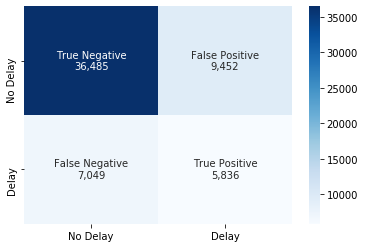

In [0]:
#Create a vector of the numeric columns that need standardization
numericalColumns = ["CRS_ELAPSED_TIME", "DISTANCE", "LATITUDE", "LONGITUDE", "ELEVATION", "TEMP", "DEW_TEMP", "SLPRESS"]
numericalCols_vector = VectorAssembler(inputCols=numericalColumns, outputCol="numerical_features")
stages_standardize = [numericalCols_vector]

#Run pipeline to create vector of numerical columns in training data
partialPipeline_standardize = Pipeline().setStages(stages_standardize)
pipelineModel_standardize = partialPipeline_standardize.fit(train_data_3m_baseline)
trainingData_standardize_vector = pipelineModel_standardize.transform(train_data_3m_baseline)

#Run pipeline to create vector of numerical columns in validation data
partialPipeline_standardize = Pipeline().setStages(stages_standardize)
pipelineModel_standardize = partialPipeline_standardize.fit(validation_data_3m_baseline)
validationData_standardize_vector = pipelineModel_standardize.transform(validation_data_3m_baseline)

#Standardize training data - fit and transform
Scalerizer = StandardScaler().setInputCol("numerical_features").setOutputCol("standardized_features")
trainingData_standards = Scalerizer.fit(trainingData_standardize_vector)
trainingData_standardized = trainingData_standards.transform(trainingData_standardize_vector)

#Standardize validation data - transform
validationData_standardized = trainingData_standards.transform(validationData_standardize_vector)

#Run data through pipeline
categoricalColumns = ["DAY_OF_WEEK", "OP_UNIQUE_CARRIER", "ORIGIN", "ORIGIN_STATE_ABR", "DEST", "DEST_STATE_ABR", "FIRST_DEP", "CRS_DEP_TIME_BUCK", "WND_SPEED_BUCK", "CIG_HEIGHT_BUCK", "VIS_DIST_BUCK"]
numericCols = ['standardized_features']
pipelineOutput_lr = pipeline_helper_lr(categoricalColumns, numericCols)

#Fit and transform data using pipeline
train_dataset_lr, validation_dataset_lr = pipeline_fit_transform(pipelineOutput_lr, trainingData_standardized, validationData_standardized)

#Call function to add class weights
train_dataset_with_weights_lr = class_weights_helper(train_dataset_lr)

#Cache prepared datasets
train_dataset_with_weights_lr.cache()
validation_dataset_lr.cache()

# Create initial LogisticRegression model
lr = LogisticRegression(labelCol="label", featuresCol="final_features", weightCol = "classWeights", maxIter=10)

# Train model with Training Data
lrModel = lr.fit(train_dataset_with_weights_lr)

# Make predictions on validation data using the transform() method.
predictions_lr = lrModel.transform(validation_dataset_lr)

# Display metrics and confusion matrix
display_metrics(predictions_lr)

#Get coefficients for feature importance
attrs = sorted(
    (attr["idx"], attr["name"]) for attr in (chain(*predictions_lr
        .schema[lrModel.summary.featuresCol]
        .metadata["ml_attr"]["attrs"].values())))

coefficients = [(name, lrModel.coefficients[idx]) for idx, name in attrs]
coefficients.sort(key = lambda x: x[1])  

for item in coefficients:
  print(item)

Using the numbers in the confusion matrix above, we can see that of the flights that were delayed, we are predicting 45% of them. We also see that this initial baseline model has an F1 score of 0.414. The results above also show the importance of each feature. Since we one hot encoded the categorical variables, we have many features. There is a feature for each origin and destination airport and we see that several of the destination airports are the more important features. We also see something interesting, that the feature indicating whether or not the flight was an airport's first departure of the day is an important feature.  

We then applied some basic tuning by adjusting the regularization parameter and elastic net parameter, as shown in the *Logistic Regression Model Tuning Function* code block below.

#### Tuning

In [0]:
#Define function for tuning Logistic Regression Models
def lr_tuning(train, validation, regParamVal, elasticNetParamVal):
  #Create model
  lr_tuning = LogisticRegression(labelCol="label", featuresCol="final_features", weightCol = "classWeights", maxIter=10, regParam=regParamVal, elasticNetParam=elasticNetParamVal)
  
  #Train model with training data
  lrModel_tuning = lr_tuning.fit(train)
  
  #Make predictions on test data using transform method
  predictions_tuning = lrModel_tuning.transform(validation)
  
  #Evaluate
  evaluator = BinaryClassificationEvaluator()
  auc_tuning = evaluator.evaluate(predictions_tuning, {evaluator.metricName: 'areaUnderROC'})

  # Calculate the elements of the confusion matrix
  TN = predictions_tuning.filter('prediction = 0 AND label = prediction').count()
  TP = predictions_tuning.filter('prediction = 1 AND label = prediction').count()
  FN = predictions_tuning.filter('prediction = 0 AND label <> prediction').count()
  FP = predictions_tuning.filter('prediction = 1 AND label <> prediction').count()

  # calculate accuracy, precision, recall, and F1-score
  accuracy = (TN + TP) / (TN + TP + FN + FP)
  precision = TP / (TP + FP)
  recall = TP / (TP + FN)
  F =  2 * (precision*recall) / (precision + recall)

  #Display results
  print("-------------------------")
  print('RegParam:', regParamVal)
  print('ElasticNetParam:', elasticNetParamVal)
  print('AUC: %0.3f' % auc_tuning)
  print('precision: %0.3f' % precision)
  print('recall: %0.3f' % recall)
  print('accuracy: %0.3f' % accuracy)
  print('F1 score: %0.3f' % F)
  print("-------------------------")
  
  return lrModel_tuning, predictions_tuning


In [0]:
#Call function to tune
lr_model1, predictions_model1 = lr_tuning(train_dataset_with_weights_lr, validation_dataset_lr, 0.1, 0) #This is L2 Ridge Regularization
lr_model2, predictions_model2 = lr_tuning(train_dataset_with_weights_lr, validation_dataset_lr, 0.1, 1) #This is L1 Lasso Regularization
lr_model3, predictions_model3 = lr_tuning(train_dataset_with_weights_lr, validation_dataset_lr, 0.01, 0) #This is L2 Ridge Regularization
lr_model4, predictions_model4 = lr_tuning(train_dataset_with_weights_lr, validation_dataset_lr, 0.01, 1) #This is L1 Lasso Regularization

-------------------------
RegParam: 0.1
ElasticNetParam: 0
AUC: 0.667
precision: 0.359
recall: 0.458
accuracy: 0.702
F1 score: 0.402
-------------------------
-------------------------
RegParam: 0.1
ElasticNetParam: 1
AUC: 0.594
precision: 0.278
recall: 0.437
accuracy: 0.628
F1 score: 0.340
-------------------------
-------------------------
RegParam: 0.01
ElasticNetParam: 0
AUC: 0.675
precision: 0.381
recall: 0.453
accuracy: 0.719
F1 score: 0.414
-------------------------
-------------------------
RegParam: 0.01
ElasticNetParam: 1
AUC: 0.627
precision: 0.259
recall: 0.521
accuracy: 0.569
F1 score: 0.346
-------------------------

AUC: 0.675
precision: 0.381
recall: 0.453
accuracy: 0.719
F1 score: 0.414
('DESTclassVec_ONT', -2.479481817913053)
('DESTclassVec_MSO', -2.3871474058645714)
('FIRST_DEPclassVec_0', -2.3125786257686274)
('CRS_DEP_TIME_BUCKclassVec_2.0', -1.598772167619547)
('DESTclassVec_OGG', -1.2425377676327793)
('CRS_DEP_TIME_BUCKclassVec_3.0', -1.1353489318540244)
('OP_UNIQUE_CARRIERclassVec_VX', -0.8916270129300911)
('DESTclassVec_ERI', -0.886430217397035)
('DESTclassVec_PSP', -0.8723429169118252)
('DESTclassVec_FCA', -0.8525046257203012)
('DESTclassVec_OAK', -0.7581480003366953)
('OP_UNIQUE_CARRIERclassVec_AS', -0.7330418080587903)
('DESTclassVec_PAH', -0.6925124300986427)
('CRS_DEP_TIME_BUCKclassVec_4.0', -0.6095942424354034)
('VIS_DIST_BUCKclassVec_1.0', -0.6094666532835316)
('DESTclassVec_EAU', -0.6070119304455879)
('DESTclassVec_CMX', -0.561761035053383)
('OP_UNIQUE_CARRIERclassVec_US', -0.5120543282103963)
('DESTclassVec_CHS', -0.4778102171758894)
('DAY_OF_WEEKclassVec_6', -0.43740831401661895)
('OP_UNIQUE_CARRIERclassVec_DL', -0.4176835857046155)
('DESTclassVec_SAV', -0.41036566181906137)
('DESTclassVec_SNA', -0.4087939324923142)
('OP_UNIQUE_CARRIERclassVec_B6', -0.40082886065855994)
('OP_UNIQUE_CARRIERclassVec_AA', -0.39929877921169554)
('standardized_features_5', -0.3454705576587582)
('DESTclassVec_VLD', -0.3448887169111325)
('DESTclassVec_GRR', -0.3388785974740893)
('WND_SPEED_BUCKclassVec_0.0', -0.33313829919913907)
('DESTclassVec_ROC', -0.3320100167635081)
('DESTclassVec_CAK', -0.3253708680680867)
('DESTclassVec_TRI', -0.3228205047671393)
('DESTclassVec_LAN', -0.3075090255876086)
('CRS_DEP_TIME_BUCKclassVec_5.0', -0.3034551737459857)
('DESTclassVec_ILM', -0.2878538817177583)
('DESTclassVec_SRQ', -0.27592215601152115)
('DESTclassVec_FWA', -0.2537434218825078)
('DESTclassVec_SPI', -0.2490755141235551)
('DESTclassVec_VPS', -0.24526037406185028)
('DESTclassVec_BIS', -0.2448444848254132)
('DESTclassVec_FSM', -0.24349809590602123)
('DESTclassVec_FAY', -0.24289670186052667)
('DESTclassVec_HOU', -0.23474664470268655)
('DESTclassVec_MDW', -0.23128382149982532)
('DESTclassVec_ABY', -0.23115702087703727)
('DESTclassVec_PIA', -0.22994120219170242)
('DESTclassVec_SHV', -0.2257522946485593)
('DAY_OF_WEEKclassVec_3', -0.22417585295093778)
('standardized_features_6', -0.21486089066366826)
('DESTclassVec_TUL', -0.2024250771661403)
('DESTclassVec_PVD', -0.20107034617660172)
('DEST_STATE_ABRclassVec_RI', -0.20107034617660172)
('DESTclassVec_MLB', -0.20083521424630288)
('DAY_OF_WEEKclassVec_5', -0.19542909182999874)
('DESTclassVec_MDT', -0.19266142363603955)
('DESTclassVec_SAN', -0.1916138900686792)
('DESTclassVec_DLH', -0.1845655962142996)
('WND_SPEED_BUCKclassVec_1.0', -0.18287869199322926)
('DESTclassVec_CLE', -0.17975895232765962)
('DESTclassVec_CLT', -0.17681967313621216)
('DESTclassVec_MSN', -0.16577642756552774)
('DESTclassVec_DFW', -0.16305554311889153)
('DESTclassVec_MLI', -0.16291148373058173)
('DESTclassVec_DAB', -0.1527370429495551)
('DESTclassVec_SGF', -0.1523371659198454)
('DESTclassVec_JAN', -0.1486379856096585)
('DESTclassVec_MOB', -0.14846648267665374)
('DESTclassVec_DAY', -0.14401078617150528)
('DESTclassVec_DHN', -0.14206253030630814)
('CRS_DEP_TIME_BUCKclassVec_6.0', -0.1362299398123522)
('DEST_STATE_ABRclassVec_ND', -0.13519189668236123)
('DESTclassVec_FLL', -0.13270132838978047)
('DESTclassVec_LAS', -0.1325331152169118)
('DESTclassVec_MIA', -0.12792505672907659)
('DEST_STATE_ABRclassVec_SC', -0.1256001018889587)
('DESTclassVec_MSY', -0.12494842010348063)
('DESTclassVec_AUS', -0.1243439888229832)
('DESTclassVec_OMA', -0.12375875948585256)
('DESTclassVec_PHX', -0.12214702548388408)
('DESTclassVec_AEX', -0.12076247063523955)
('DEST_STATE_ABRclassVec_NE', -0.1190436993721732)
('DESTclassVec_SBN', -0.11900046344937901)
('DESTclassVec_MGM', -0.11541762748537858)
('DESTclassVec_PDX', -0.11527734381419197)
('DEST_STATE_ABRclassVec_OR', -0.11527734381419197)
('DESTclassVec_FAR', -0.11473491439736713)
('DESTclassVec_STL', -0.1140797820

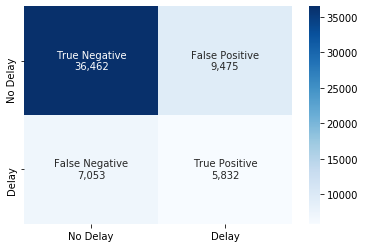

In [0]:
#Make directory to save models
#dbutils.fs.mkdirs("dbfs:/mnt/mids-w261/team_25/models_folder")               #Made Directory in DataBricks, no need to remake

#Save best model                 
modelPath = "dbfs:/mnt/mids-w261/team_25/models_folder"
filename = "best_lr_model"
lr_model3.save(modelPath+filename)

#Code to reload model if needed
#sameLRModel = LogisticRegressionModel.load(modelPath+filename)

#View confusion matrix and coefficients for best model
#Call function to display metrics and confusion matrix
display_metrics(predictions_model3)

#Get coefficients for feature importance
attrs = sorted(
    (attr["idx"], attr["name"]) for attr in (chain(*predictions_lr
        .schema[lrModel.summary.featuresCol]
        .metadata["ml_attr"]["attrs"].values())))

coefficients = [(name, lrModel.coefficients[idx]) for idx, name in attrs]
coefficients.sort(key = lambda x: x[1])  

for item in coefficients:
  print(item)

As shown in the metrics and confusion matrix above, after some basic tuning we do not see an improvement in the model's results. F1 score remains at 0.414.

## Decision Tree Baseline Model

After running our initial baseline logistic regression model, we then tried running a decision tree model to see how a different type of model would perform and because a decision tree is a simple and easy to interpret model. Additionally, a decision tree model can easily handle categorical features without one hot encoding and we had several features. We used the same train and validation datasets as for the logistic regression model. We again created this initial decision tree baseline using all of the features in the data. In contrast to the logistic regression model, we did not standardize the continuous data, nor did we one hot encode the categorical data. We did follow the same process as the logistic regression model of using `StringIndexer` to encode the categorical variables and to indicate the outcome variable. We also used `VectorAssembler` to compile all the features into a single vector and compiled all of these preprocessing steps into a pipeline that we then fit to the training data and then used to transform both the training and validation data. We also applied the same weighting to the data using the "Balancing Ratio." We then created a decision tree model and fit it using the training data. We made predictions by transforming the validation data. The code for the model is shown in the *Decision Tree Model* code block below.

numNodes = 43
depth = 5

treeNode {"index":19,"featureType":"continuous","prediction":null,"threshold":-58.5,"categories":null,"feature":17,"overflow":false} {"index":7,"featureType":"categorical","prediction":null,"threshold":null,"categories":[1.0,2.0,3.0,4.0,5.0,8.0],"feature":7,"overflow":false} {"index":1,"featureType":"categorical","prediction":null,"threshold":null,"categories":[2.0,3.0,6.0,8.0,9.0],"feature":1,"overflow":false} {"index":0,"featureType":null,"prediction":1.0,"threshold":null,"categories":null,"feature":null,"overflow":false} {"index":3,"featureType":"continuous","prediction":null,"threshold":10282.5,"categories":null,"feature":19,"overflow":false} {"index":2,"featureType":null,"prediction":1.0,"threshold":null,"categories":null,"feature":null,"overflow":false} {"index":5,"featureType":"categorical","prediction":null,"threshold":null,"categories":[4.0,6.0],"feature":0,"overflow":false} {"index":4,"featureType":null,"prediction":1.0,"threshold":null,"categories":null,"feature":null,"overflow":false} {"index":6,"featureType":null,"prediction":0.0,"threshold":null,"categories":null,"feature":null,"overflow":false} {"index":13,"featureType":"continuous","prediction":null,"threshold":-114.0,"categories":null,"feature":17,"overflow":false} {"index":9,"featureType":"categorical","prediction":null,"threshold":null,"categories":[2.0,5.0,6.0,8.0,9.0],"feature":1,"overflow":false} {"index":8,"featureType":null,"prediction":1.0,"threshold":null,"categories":null,"feature":null,"overflow":false} {"index":11,"featureType":"categorical","prediction":null,"threshold":null,"categories":[1.0,2.0,3.0],"feature":8,"overflow":false} {"index":10,"featureType":null,"prediction":0.0,"threshold":null,"categories":null,"feature":null,"overflow":false} {"index":12,"featureType":null,"prediction":1.0,"threshold":null,"categories":null,"feature":null,"overflow":false} {"index":15,"featureType":"categorical","prediction":null,"threshold":null,"categories":[0.0,1.0,4.0,5.0,7.0,11.0,12.0],"feature":1,"overflow":false} {"index":14,"featureType":null,"prediction":0.0,"threshold":null,"categories":null,"feature":null,"overflow":false} {"index":17,"featureType":"categorical","prediction":null,"threshold":null,"categories":[1.0],"feature":9,"overflow":false} {"index":16,"featureType":null,"prediction":0.0,"threshold":null,"categories":null,"feature":null,"overflow":false} {"index":18,"featureType":null,"prediction":1.0,"threshold":null,"categories":null,"feature":null,"overflow":false} {"index":33,"featureType":"categorical","prediction":null,"threshold":null,"categories":[1.0],"feature":10,"overflow":false} {"index":25,"featureType":"categorical","prediction":null,"threshold":null,"categories":[2.0,3.0,4.0,8.0,9.0],"feature":7,"overflow":false} {"index":23,"featureType":"categorical","prediction":null,"threshold":null,"categories":[3.0,4.0,5.0],"feature":0,"overflow":false} {"index":21,"featureType":"continuous","prediction":null,"threshold":10225.5,"categories":null,"feature":19,"overflow":false} {"index":20,"featureType":null,"prediction":1.0,"threshold":null,"categories":null,"feature":null,"overflow":false} {"index":22,"featureType":null,"prediction":0.0,"threshold":null,"categories":null,"feature":null,"overflow":false} {"index":24,"featureType":null,"prediction":1.0,"threshold":null,"categories":null,"feature":null,"overflow":false} {"index":29,"featureType":"continuous","prediction":null,"threshold":8.5,"categories":null,"feature":17,"overflow":false} {"index":27,"featureType":"categorical","prediction":null,"threshold":null,"categories":[4.0,6.0],"feature":0,"overflow":false} {"index":26,"featureType":null,"prediction":1.0,"threshold":null,"categories":null,"feature":null,"overflow":false} {"index":28,"featureType":null,"prediction":0.0,"threshold":null,"categories":null,"feature":null,"overflow":false} {"index":31,"featureType":"categorical","prediction":null,"threshold":null,"categories":[0.0],"feature":6,"overflow":false} {"index":30,"featureType":null,

AUC: 0.406
precision: 0.340
recall: 0.411
accuracy: 0.696
F1 score: 0.372
Out[13]:

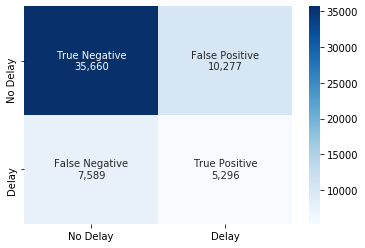

idx 
 name 
 vals 
 score 
 
 
 
 
 5 
 17 
 TEMP 
 NaN 
 0.413059 
 
 
 18 
 10 
 VIS_DIST_BUCKIndex 
 [1.0, 0.0, __unknown] 
 0.170865 
 
 
 9 
 1 
 OP_UNIQUE_CARRIERIndex 
 [DL, EV, MQ, UA, AA, WN, OO, US, NK, F9, B6, A... 
 0.133620 
 
 
 15 
 7 
 CRS_DEP_TIME_BUCKIndex 
 [4.0, 6.0, 8.0, 9.0, 10.0, 7.0, 5.0, 3.0, 11.0... 
 0.130976 
 
 
 8 
 0 
 DAY_OF_WEEKIndex 
 [5, 4, 2, 3, 1, 6, 7, __unknown] 
 0.062214 
 
 
 14 
 6 
 FIRST_DEPIndex 
 [0, 1, __unknown] 
 0.055387 
 
 
 7 
 19 
 SLPRESS 
 NaN 
 0.019067 
 
 
 16 
 8 
 WND_SPEED_BUCKIndex 
 [2.0, 1.0, 0.0, 3.0, __unknown] 
 0.008511 
 
 
 17 
 9 
 CIG_HEIGHT_BUCKIndex 
 [0.0, 1.0, __unknown] 
 0.006301 
 
 
 0 
 12 
 CRS_ELAPSED_TIME 
 NaN 
 0.000000

In [0]:
#Run data through pipeline
categoricalColumns = ["DAY_OF_WEEK", "OP_UNIQUE_CARRIER", "ORIGIN", "ORIGIN_STATE_ABR", "DEST", "DEST_STATE_ABR", "FIRST_DEP", "CRS_DEP_TIME_BUCK", "WND_SPEED_BUCK", "CIG_HEIGHT_BUCK", "VIS_DIST_BUCK", "VIS_VAR"]
numericCols = ['CRS_ELAPSED_TIME', 'DISTANCE', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'TEMP', 'DEW_TEMP', 'SLPRESS']
pipelineOutput = pipeline_helper_trees(categoricalColumns, numericCols)

#Fit and transform data using pipeline
train_dataset, validation_dataset = pipeline_fit_transform(pipelineOutput, train_data_3m_baseline, validation_data_3m_baseline)

#Call function to add class weights
train_dataset_with_weights = class_weights_helper(train_dataset)

#Cache prepared datasets
train_dataset_with_weights.cache()
validation_dataset.cache()

#Create initial Decision Tree Model
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features", weightCol="classWeights", maxDepth=5, maxBins=181)

#Train model with training data
dtModel = dt.fit(train_dataset_with_weights)

#Make predictions on validation data using the Transformer.transform() method.
predictions_DT = dtModel.transform(validation_dataset)

#Display decision tree model
print("numNodes = ", dtModel.numNodes)
print("depth = ", dtModel.depth)
display(dtModel)

#Call function to display metrics and confusion matrix
display_metrics(predictions_DT)

#View feature importance
ExtractFeatureImp(dtModel.featureImportances, train_dataset_with_weights, "features").head(10)

We see from the metrics above that this baseline decision tree model has a F1 score of 0.372. Additionally, from the confusion matrix we see that of the flights that are actually delayed, we predicted that 41% of them would be delayed. We also see that the most important feature is temperature, which is different from our logistic regression model where we did not see temperature among the most important features. Some of the other most important features we see are: visibility distance, carrier, and departure time. We then applied some basic tuning by adjusting the maximum depth of the tree and maximum number of bins allowed, which is show in the *Decision Tree Model Tuning Function* code block below.

#### Tuning

In [0]:
#Define function for tuning Decision Tree Models
def dt_tuning(train, validation, maxDepthVal, maxBinsVal):
  
  #Create model
  dt_tuning = DecisionTreeClassifier(labelCol="label", featuresCol="features", weightCol="classWeights", maxDepth=maxDepthVal, maxBins=maxBinsVal)  
  
  #Train model with training data
  dtModel_tuning = dt_tuning.fit(train)
  
  #Make predictions on test data using transform method
  predictions_tuning = dtModel_tuning.transform(validation)
  
  #Evaluate
  evaluator = BinaryClassificationEvaluator()
  auc_tuning = evaluator.evaluate(predictions_tuning, {evaluator.metricName: 'areaUnderROC'})

  # Calculate the elements of the confusion matrix
  TN = predictions_tuning.filter('prediction = 0 AND label = prediction').count()
  TP = predictions_tuning.filter('prediction = 1 AND label = prediction').count()
  FN = predictions_tuning.filter('prediction = 0 AND label <> prediction').count()
  FP = predictions_tuning.filter('prediction = 1 AND label <> prediction').count()

  # calculate accuracy, precision, recall, and F1-score
  accuracy = (TN + TP) / (TN + TP + FN + FP)
  precision = TP / (TP + FP)
  recall = TP / (TP + FN)
  F =  2 * (precision*recall) / (precision + recall)

  #Display results
  print("-------------------------")
  print('Max Depth:', maxDepthVal)
  print('Max Bins:', maxBinsVal)
  print('AUC: %0.3f' % auc_tuning)
  print('precision: %0.3f' % precision)
  print('recall: %0.3f' % recall)
  print('accuracy: %0.3f' % accuracy)
  print('F1 score: %0.3f' % F)
  print("-------------------------")
  
  return dtModel_tuning, predictions_tuning

In [0]:
#Call function to tune
dt_model1, predictions_model1 = dt_tuning(train_dataset_with_weights, validation_dataset, 6, 181)
dt_model2, predictions_model2 = dt_tuning(train_dataset_with_weights, validation_dataset, 8, 300)
dt_model3, predictions_model3 = dt_tuning(train_dataset_with_weights, validation_dataset, 6, 300)
dt_model4, predictions_model4 = dt_tuning(train_dataset_with_weights, validation_dataset, 8, 181)

-------------------------
Max Depth: 6
Max Bins: 181
AUC: 0.437
precision: 0.314
recall: 0.460
accuracy: 0.662
F1 score: 0.373
-------------------------
-------------------------
Max Depth: 8
Max Bins: 300
AUC: 0.419
precision: 0.328
recall: 0.403
accuracy: 0.688
F1 score: 0.361
-------------------------
-------------------------
Max Depth: 6
Max Bins: 300
AUC: 0.436
precision: 0.318
recall: 0.453
accuracy: 0.668
F1 score: 0.374
-------------------------
-------------------------
Max Depth: 8
Max Bins: 181
AUC: 0.420
precision: 0.333
recall: 0.402
accuracy: 0.692
F1 score: 0.364
-------------------------

AUC: 0.436
precision: 0.318
recall: 0.453
accuracy: 0.668
F1 score: 0.374
Out[18]:

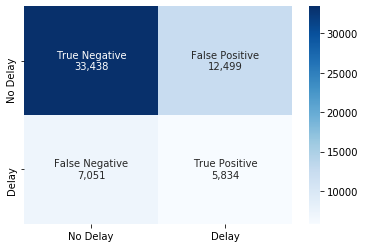

idx 
 name 
 vals 
 score 
 
 
 
 
 5 
 17 
 TEMP 
 NaN 
 0.382918 
 
 
 18 
 10 
 VIS_DIST_BUCKIndex 
 [1.0, 0.0, __unknown] 
 0.158720 
 
 
 15 
 7 
 CRS_DEP_TIME_BUCKIndex 
 [4.0, 6.0, 8.0, 9.0, 10.0, 7.0, 5.0, 3.0, 11.0... 
 0.122421 
 
 
 9 
 1 
 OP_UNIQUE_CARRIERIndex 
 [DL, EV, MQ, UA, AA, WN, OO, US, NK, F9, B6, A... 
 0.122036 
 
 
 8 
 0 
 DAY_OF_WEEKIndex 
 [5, 4, 2, 3, 1, 6, 7, __unknown] 
 0.067301 
 
 
 14 
 6 
 FIRST_DEPIndex 
 [0, 1, __unknown] 
 0.054777 
 
 
 12 
 4 
 DESTIndex 
 [LGA, DFW, MCO, DCA, CLT, LAX, FLL, MSP, MIA, ... 
 0.046598 
 
 
 7 
 19 
 SLPRESS 
 NaN 
 0.017486 
 
 
 6 
 18 
 DEW_TEMP 
 NaN 
 0.014236 
 
 
 16 
 8 
 WND_SPEED_BUCKIndex 
 [2.0, 1.0, 0.0, 3.0, __unknown] 
 0.007761

In [0]:
#Save best model                 
modelPath = "dbfs:/mnt/mids-w261/team_25/models_folder"
filename = "best_dt_3m_model"
dt_model3.save(modelPath+filename)

#Code to reload model if needed
#best_dt_3m_model = DecisionTreeClassificationModel.load(modelPath+filename)

#View confusion matrix and coefficients for best model
#Call function to display metrics and confusion matrix
display_metrics(predictions_model3)

# #View feature importance
ExtractFeatureImp(dt_model3.featureImportances, train_dataset_with_weights, "features").head(10)

As shown above, we did not see much of an improvement after tuning, as our F1 score was 0.374. We also see that our best model after tuning has the same top 4 most important features. We were surprised that the logistic regression performed better than the decision tree. We expected the decision tree to perform better based on the literature that we read where many others had solved this problem well using decision trees. Even though our decision tree model did not perform quite as well as the logistic regression model, we decided to proceed with a decision tree model since it's ability to handle null values would allow us to capture more of the variance in our training data. The trade-off with using logistic regression is that the model cannot handle any null data and requires the data to be one hot encoded. We believe that the model's ability to handle null data made it a better choice for business reasons. Therefore in the future if we were provided data to make delay predictions on and we used a decision tree, then our model would still be able to accept and make predictions if the data contained any null values. We also believe that with more tuning of our initial decision tree we could exceed the performance of the logistic regression model and with an initial decision tree model this can be expanded to ensemble models, such as random forest or gradient boosted trees, which we then tested.

We created 2 additional models on the same 3 month dataset - a random forest model and a gradient boosted tree model. We wanted to build and improve upon our decision tree model, so we next tried a random forest model, since it is an ensemble algorithm and considers the results of multiple decision trees to arrive at a solution. Then to further build on this we created a gradient boosted tree model since it is another ensemble method and builds one tree at a time so that each new tree works to correct errors made by the previous tree. For both models, we followed the same data preparation process as for the decision tree model. We used the same train and validation datasets and again created these initial models using all of the features in the data. We again used `StringIndexer` to encode the categorical variables and to indicate the outcome variable. We also used `VectorAssembler` to compile all the features into a single vector and compiled all of these preprocessing steps into a pipeline that we then fit to the training data and then used to transform both the training and validation data. We also applied the same weighting to the data using the "Balancing Ratio." We then created the model and fit it using the training data. We made predictions by transforming the validation data. For the random forest model we did basic tuning by adjusting the maximum depth and number of trees. For the gradient boosted tree model we did basic tuning by adjusting the maximum depth. The code for these 2 models can be viewed here - https://dbc-c4580dc0-018b.cloud.databricks.com/?o=8229810859276230#notebook/4061768275125789/command/4061768275125997.

The image below shows a side by side comparison of the confusion matrices and metrics for all 4 initial models on the 3 month dataset. Since our goal was to optimize F1 score and the gradient boosted tree model had the best F1 score, we proceeded with a gradient boosted tree model and then worked to improve the model with feature engineering, feature transformations and hyperparameter tuning.

<img src="https://raw.githubusercontent.com/jaclynandrews/for_w261_final_project/main/baseline_model_confusion_matrices.png", width=1200, height=550>

# 5. Algorithm Implementation

## Toy Example

We've chosen to implement a Gradient Boosted Tree for our prediction model. A Gradient Boosted Tree results from training a sequence of Decision Trees using the last tree's residual outputs to train the next tree. The small example below shows a dataset for predicting flight delays using two features - `Airline` and `Time`. To prepare for our gradient boosted tree, we first take the total delay rate and find a residual for each observation by subtracting the delay rate from the actual delay. This represents our first prediction, not using any of the feature information.

In [0]:
toy_data = [["JetBlue","Morning",0, 0.5, -0.5, -2, 0.1, 0.3, -0.3], 
 ["JetBlue","Morning",0, 0.5, -0.5, -2, 0.1, 0.3, -0.3], 
 ["JetBlue","Night",0, 0.5, -0.5, 0, 0.1, 0.5, -0.5], 
 ["JetBlue","Night",1, 0.5, 0.5, 0, 0.1, 0.5, 0.5], 
 ["American","Morning",1, 0.5, 0.5, 2, 0.1, 0.7, 0.3], 
 ["American","Night",1, 0.5, 0.5, 1.2, 0.1, 0.62, 0.38], 
 ["American","Night",1, 0.5, 0.5, 1.2, 0.1, 0.62, 0.38],
 ["American","Night",0, 0.5, -0.5, 1.2, 0.1, 0.62, -0.62],
 ["Southwest","Morning",0, 0.5, -0.5, -2, 0.1, 0.3, -0.3],
 ["Southwest","Morning",0, 0.5,-0.5, -2, 0.1, 0.3, -0.3],
 ["Southwest","Night",1, 0.5, 0.5, 1.2, 0.1, 0.62, 0.38],
 ["Southwest","Night",1, 0.5, 0.5, 1.2, 0.1, 0.62, 0.38]]


toy_pdf = pd.DataFrame(toy_data, columns=["Airline", "Time", "Delay", "Prediction1", "Residual1", "Gamma", "LearningRate", "Prediction2", "Residual2"])
toy_pdf_sub = toy_pdf[["Airline", "Time", "Delay", "Prediction1", "Residual1"]]
toy_pdf_sub

Out[3]:

Airline 
 Time 
 Delay 
 Prediction1 
 Residual1 
 
 
 
 
 0 
 JetBlue 
 Morning 
 0 
 0.5 
 -0.5 
 
 
 1 
 JetBlue 
 Morning 
 0 
 0.5 
 -0.5 
 
 
 2 
 JetBlue 
 Night 
 0 
 0.5 
 -0.5 
 
 
 3 
 JetBlue 
 Night 
 1 
 0.5 
 0.5 
 
 
 4 
 American 
 Morning 
 1 
 0.5 
 0.5 
 
 
 5 
 American 
 Night 
 1 
 0.5 
 0.5 
 
 
 6 
 American 
 Night 
 1 
 0.5 
 0.5 
 
 
 7 
 American 
 Night 
 0 
 0.5 
 -0.5 
 
 
 8 
 Southwest 
 Morning 
 0 
 0.5 
 -0.5 
 
 
 9 
 Southwest 
 Morning 
 0 
 0.5 
 -0.5 
 
 
 10 
 Southwest 
 Night 
 1 
 0.5 
 0.5 
 
 
 11 
 Southwest 
 Night 
 1 
 0.5 
 0.5

Our airline variable has 3 classes, which would normally lead to 3 potential split points, but using Breiman's method reduces that to 2 (or \\(k-1\\)) split points. Spark implements Breiman's method automatically to more efficiently build the decision tree. First, we calculated each airline's delay rate, then ordered them.

\\(P(Delay)_{JetBlue} = 0.75\\)

\\(P(Delay)_{American} = 0.25\\)

\\(P(Delay)_{Southwest} = 0.5\\)

So we either split by American vs. the others or by JetBlue vs. the others.

We will build our decision tree using the gini index of impurity to determine split points. The gini index fall between 0 and 1 and measures how impure our leafs are when we split our data in different ways. In general, the more of an even split of delays and not delays we have in a leaf after a split, the higher our gini index will be. We choose the purest split with the lowest gini index. The calculations below show how we arrive at using `Time` instead of either of the airport splits to initially split the data, since the weighted gini indices are 0.371 for `Time` and  and 0.438 for each of the airline splits. We follow the same process for the second layer of the tree to split each of the `Morning` and `Night` nodes.

<img src="https://raw.githubusercontent.com/jaclynandrews/for_w261_final_project/main/Screen%20Shot%202020-12-11%20at%2012.05.22%20AM.png", width=1000, height=600>

We arrive at the decision tree below. We could stop there and use this decision tree for prediction, but instead with a GBM we highlight the areas this tree didn’t predict well and improve there. To do this, we place our residuals on their respective leaves and calculate a gamma value for each leaf. The gamma value has a longer derivation but ultimately stems from us minimizing the log loss function. The formula and calculation for leaf 2’s gamma is below. Gamma’s sign and magnitude will indicate the direction and relative change from the last prediction that you are moving. Since the algorithm is running gradient descent to iteratively hone in on an accurate prediction for each observation, the gamma value is vitally important to ensure that the right steps are taken.

<img src="https://raw.githubusercontent.com/jaclynandrews/for_w261_final_project/main/Screen%20Shot%202020-12-11%20at%2012.06.14%20AM.png", width=800, height=450>

We first multiply by a learning rate like we always do with gradient descent to ensure that we don’t overshoot the correct prediction. We add that to our previous prediction of 0.5 to get our second prediction. Now we can see we’ve moved in the right direction since the predictions that increased were for delays and the ones that decreased were for on time departures. From there, we would run another tree using the residuals as the outcome variable and repeat until the max iterations value was met or residuals became very small. 

The confusion matrix below shows that even with one iteration, Gradient Boosting Tree algorithm was able to accurately predict 10 out of 12 flights in the toy set. 


<img src="https://raw.githubusercontent.com/jaclynandrews/for_w261_final_project/main/Screen%20Shot%202020-12-11%20at%2012.07.42%20AM.png", width=1200>

Because gradient boosted trees follow the iterative gradient descent algorithm, building the trees is not a parallelizeable action. Each tree requires the residuals from the last tree as the inputed outcome variable, so the entire previous tree needs to have been calculated before the new tree starts being calculated. In addition, individual trees are difficult to parallelize because they can only go one layer deep at a time. However, within a layer, the impurity calculations can occur in parallel. The power of gradient boosted trees improving weak areas of the previous tree and being very flexible with inputted values outweighs some of the negative aspects of parallelization.

AUC: 0.931
precision: 0.750
recall: 1.000
accuracy: 0.833
F1 score: 0.857
Out[6]:

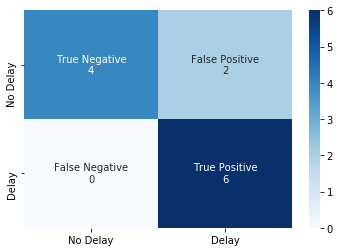

vals 
 idx 
 name 
 score 
 
 
 
 
 0 
 [American, JetBlue, Southwest, __unknown] 
 0 
 AirlineIndex 
 0.666762 
 
 
 1 
 [Night, Morning, __unknown] 
 1 
 TimeIndex 
 0.333238

In [0]:
# create toy train set
toy_train = sc.parallelize([["JetBlue","Morning",0], 
 ["JetBlue","Morning",0], 
 ["JetBlue","Night",0], 
 ["JetBlue","Night",1], 
 ["American","Morning",1], 
 ["American","Night",1], 
 ["American","Night",1],
 ["American","Night",0],
 ["Southwest","Morning",0],
 ["Southwest","Morning",0],
 ["Southwest","Night",1],
 ["Southwest","Night",1]]).toDF(("Airline", "Time", "DELAY"))

#Run data through pipeline to assemble vector of categorical columns and PCA features
categoricalColumns = ["Airline", "Time"]
numericCols = []
pipelineOutput = pipeline_helper_trees(categoricalColumns, numericCols)

#Fit and transform data using pipeline
train_dataset_toy_final, train_dataset_toy_final2 = pipeline_fit_transform(pipelineOutput, toy_train, toy_train)


#Cache prepared datasets
train_dataset_toy_final.cache()
train_dataset_toy_final2.cache()

#Create Gradient Boosted Tree model
gbt_toy = GBTClassifier(labelCol="label", featuresCol="features", maxBins=316, maxDepth=2)

# Train model with Training Data
gbtModel_toy = gbt_toy.fit(train_dataset_toy_final)

# Make predictions on validation data using the Transformer.transform() method.
predictions_gbt_toy = gbtModel_toy.transform(train_dataset_toy_final)

#Display metrics
display_metrics(predictions_gbt_toy)

#Get feature importance
ExtractFeatureImp(gbtModel_toy.featureImportances, train_dataset_toy_final, "features").head(2)


#Save model                 
# modelPath = "dbfs:/mnt/mids-w261/team_25/models_folder"
# filename = "best_gbt_full_model"
# gbtModel.save(modelPath+filename)

#Code to reload model if needed
#best_gbt_fullmodel = GBTClassificationModel.load(modelPath+filename)

## Additional Modeling

After running our initial baseline gradient boosted tree model we ran several additional models before arriving at a final model. We tested out different feature transformations and adding in additional engineered features to try and improve the model's performance. For testing purposes we continued to work with a 3 month dataset, but switched to a different 3 month dataset than used in our initial baseline models. We switched to using a 3 month dataset that still consisted of flights from January through March 2015, but we included all airports, not solely ATL and ORD. We needed to include all airports in order to test out some of our engineered features. Working in "a small world" with the 3 month dataset allowed us to test out modeling, features and hyperparameter tuning and then when we determined the best model, we could apply it to the full 5 year dataset.

We first ran 4 gradient boosted tree models, adding a new engineered feature each time. We first added the PageRank feature, but this did not result in a change in our F1 score. Next we added in the feature that indicated if the previous flight with that same tail number was delayed. This resulted in a 0.045 improvement in F1 score, which was the most significant improvement we had seen. We then added in 10 additional features for the weather at the destination airport. This resulted in a 0.009 improvement in F1 score. We then added in a feature indicating the total number of flights scheduled for a day, and surprisingly this actually decreased the performance of our model. This resulted in a 0.023 decrease in our F1 score. This could be because this number was not specific to an airport, but was the same number for all airports. Due to the decrease in performance when this feature was added we chose to not include it. We also tested out one hot encoding the categorical variables versus not one hot encoding them, but overall saw better results when the categorical variables were not one hot encoded. 

At this point our best model included 32 different features, so we wanted to try out different methods to reduce the number of features in order to try and improve the results. We first tried creating a Random Forest model with all 32 features, we then evaluated the the feature importances and selected the top 10 and created a gradient boosted tree model only using these top 10 features, but this resulted in a 0.041 decrease in F1 score. We then tried taking the top 10 most important features from our best gradient boosted tree model and running a new gradient boosted tree with these 10 features. This resulted in a 0.001 improvement in F1 score and was much less computationally expensive due to the fact that it used 22 fewer features.

We then tried Principal Components Analysis (PCA) to try and reduce dimensionality. In order to use PCA we first had to standardize and center the data. We then ran PCA. We adjusted the number of components, but eventually settled on 10. We then applied the same method as before and fit a gradient boosted tree model to the data and made predictions by transforming the validation data. We then did some basic tuning by adjusting the maximum depth and found that the model performed best with a maximum depth of 6. We selected this model as our final model as it had the best overall performance and it was also beneficial that PCA significantly reduced the computational cost of running the model and also generally helps with reducing overfitting. After this testing, we arrived at our final gradient boosted tree model.

All code for models described can be viewed here - https://dbc-c4580dc0-018b.cloud.databricks.com/?o=8229810859276230#notebook/4061768275125789/command/4061768275140166.
The table below shows the different models we ran on the validation and the metrics for each one. The original features refers to all the features included in our initial baseline models.

<img src="https://raw.githubusercontent.com/jaclynandrews/for_w261_final_project/main/Modeling%20Results.png", width=1200, height=450>

## Final Model

In [0]:
#Read in full 5 year data
#Read Train Data
filename = "train_data"                      
train_data = spark.read.option("header", "true").parquet("dbfs:/mnt/mids-w261/team_25/train_test_data_folder/"+filename+"/part-00*.parquet")

#Read Validation Data
filename = "validation_data"                      
validation_data = spark.read.option("header", "true").parquet("dbfs:/mnt/mids-w261/team_25/train_test_data_folder/"+filename+"/part-00*.parquet")

#Read Test Data
filename = "test_data"                      
test_data = spark.read.option("header", "true").parquet("dbfs:/mnt/mids-w261/team_25/train_test_data_folder/"+filename+"/part-00*.parquet")

AUC: 0.714
precision: 0.333
recall: 0.603
accuracy: 0.683
F1 score: 0.429

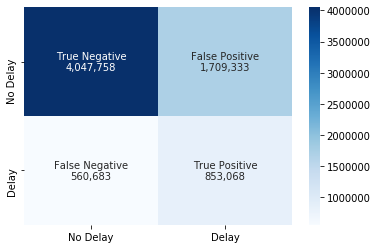

--------------------------------------------------------------------------- 
 Py4JJavaError Traceback (most recent call last)
 <command-2834511320012055> in <module> 
 67 modelPath = "dbfs:/mnt/mids-w261/team_25/models_folder" 
 68 filename = "best_gbt_full_model" 
 ---> 69 gbtModel . save ( modelPath + filename ) 
 70 
 71 #Code to reload model if needed 

 /databricks/spark/python/pyspark/ml/util.py in save (self, path) 
 262 def save ( self , path ) : 
 263 """Save this ML instance to the given path, a shortcut of 'write().save(path)'.""" 
 --> 264 self . write ( ) . save ( path ) 
 265 
 266 

 /databricks/spark/python/pyspark/ml/util.py in save (self, path) 
 213 if not isinstance ( path , basestring ) : 
 214 raise TypeError ( "path should be a basestring, got type %s" % type ( path ) ) 
 --> 215 self . _jwrite . save ( path ) 
 216 
 217 def overwrite ( self ) : 

 /databricks/spark/python/lib/py4j-0.10.9-src.zip/py4j/java_gateway.py in __call__ (self, *args) 
 1303 answer = self . gateway_client . send_command ( command ) 
 1304 return_value = get_return_value(
 -> 1305 answer, self.gateway_client, self.target_id, self.name)
 1306 
 1307 for temp_arg in temp_args : 

 /databricks/spark/python/pyspark/sql/utils.py in deco (*a, **kw) 
 125 def deco ( * a , ** kw ) : 
 126 try : 
 --> 127 return f ( * a , ** kw ) 
 128 except py4j . protocol . Py4JJavaError as e : 
 129 converted = convert_exception ( e . java_exception ) 

 /databricks/spark/python/lib/py4j-0.10.9-src.zip/py4j/protocol.py in get_return_value (answer, gateway_client, target_id, name) 
 326 raise Py4JJavaError(
 327 "An error occurred while calling {0}{1}{2}.\n" . 
 --> 328 format(target_id, ".", name), value)
 329 else : 
 330 raise Py4JError(

 Py4JJavaError : An error occurred while calling o2698.save.
: java.io.IOException: Path dbfs:/mnt/mids-w261/team_25/models_folderbest_gbt_full_model already exists. To overwrite it, please use write.overwrite().save(path) for Scala and use write().overwrite().save(path) for Java and Python.
	at org.apache.spark.ml.util.FileSystemOverwrite.handleOverwrite(ReadWrite.scala:683)
	at org.apache.spark.ml.util.MLWriter.save(ReadWrite.scala:167)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:380)
	at py4j.Gateway.invoke(Gateway.java:295)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:251)
	at java.lang.Thread.run(Thread.java:748)

In [0]:
#Create a vector of the numeric columns that need standardization
#Define numeric columns
numericalColumns = ['CRS_ELAPSED_TIME', 'DISTANCE', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'TEMP', 'DEW_TEMP', 'SLPRESS', 'PAGERANK', 'DEST_LATITUDE', 'DEST_LONGITUDE', 'DEST_ELEVATION', 'DEST_TEMP', 'DEST_DEW_TEMP', 'DEST_SLPRESS']
#Define input column names that VectorAssembler will take and combine into one vector with the specified output column name
numericalCols_vector = VectorAssembler(inputCols=numericalColumns, outputCol="numerical_features")
#Define the stage for the pipeline
stages_standardize = [numericalCols_vector]

#Run pipeline to create vector of numeric columns in training data
partialPipeline_standardize = Pipeline().setStages(stages_standardize)
pipelineModel_standardize = partialPipeline_standardize.fit(train_data)
trainingData_standardize_vector = pipelineModel_standardize.transform(train_data)

#Run pipeline to create vector of numeric columns in validation data
partialPipeline_standardize = Pipeline().setStages(stages_standardize)
pipelineModel_standardize = partialPipeline_standardize.fit(validation_data)
validationData_standardize_vector = pipelineModel_standardize.transform(validation_data)

#Standardize training data - fit and transform
Scalerizer = StandardScaler(inputCol="numerical_features", outputCol="standardized_features", withStd=True, withMean=True)
trainingData_standards = Scalerizer.fit(trainingData_standardize_vector)
trainingData_standardized = trainingData_standards.transform(trainingData_standardize_vector)

#Standardize validation data - transform
validationData_standardized = trainingData_standards.transform(validationData_standardize_vector)

#Perform PCA on the numeric features
pca = PCA(k=10, inputCol="standardized_features", outputCol="pcaFeatures")
pca_model = pca.fit(trainingData_standardized)
train_dataset_pca = pca_model.transform(trainingData_standardized)
validation_dataset_pca = pca_model.transform(validationData_standardized)

#Run data through pipeline to assemble vector of categorical columns and PCA features
categoricalColumns = ["YEAR", "MONTH", "DAY_OF_WEEK", "OP_UNIQUE_CARRIER", "ORIGIN", "ORIGIN_STATE_ABR", "DEST", "DEST_STATE_ABR", "FIRST_DEP", "CRS_DEP_TIME_BUCK", "WND_SPEED_BUCK", "CIG_HEIGHT_BUCK", "VIS_DIST_BUCK", "PREVIOUS_DELAY", "VIS_VAR", "DEST_VIS_VAR", "DEST_WND_SPEED_BUCK", "DEST_VIS_DIST_BUCK", "DEST_CIG_HEIGHT_BUCK"]
numericCols = ["pcaFeatures"]
pipelineOutput = pipeline_helper_trees(categoricalColumns, numericCols)

#Fit and transform data using pipeline
train_dataset_pca_final, validation_dataset_pca_final = pipeline_fit_transform(pipelineOutput, train_dataset_pca, validation_dataset_pca)

#Call function to add class weights
train_dataset_pca_ww = class_weights_helper(train_dataset_pca_final)

#Cache prepared datasets
train_dataset_pca_ww.cache()
validation_dataset_pca_final.cache()

#Create Gradient Boosted Tree model
gbt = GBTClassifier(labelCol="label", featuresCol="features", weightCol = "classWeights", maxBins=316, maxDepth=6)

#Train model with training data
gbtModel = gbt.fit(train_dataset_pca_ww)

#Make predictions on validation data using the Transformer.transform() method.
predictions_gbt = gbtModel.transform(validation_dataset_pca_final)

#Display metrics and confusion matrix
display_metrics(predictions_gbt)

#Get feature importance for PCA features
pc_df = pd.DataFrame(data=pca_model.pc.toArray(), index=['CRS_ELAPSED_TIME', 'DISTANCE', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'TEMP', 'DEW_TEMP', 'SLPRESS', 'PAGERANK', 'DEST_LATITUDE', 'DEST_LONGITUDE', 'DEST_ELEVATION', 'DEST_TEMP', 'DEST_DEW_TEMP', 'DEST_SLPRESS'])

#Save model                 
modelPath = "dbfs:/mnt/mids-w261/team_25/models_folder"
filename = "best_gbt_full_model"
gbtModel.save(modelPath+filename)

#Code to reload model if needed
#best_gbt_fullmodel = GBTClassificationModel.load(modelPath+filename)

In [0]:
ExtractFeatureImp(gbtModel.featureImportances, train_dataset_pca_ww, "features").head(10)

Out[5]:

idx 
 name 
 vals 
 score 
 
 
 
 
 19 
 9 
 CRS_DEP_TIME_BUCKIndex 
 [3.0, 4.0, 8.0, 5.0, 6.0, 7.0, 9.0, 10.0, 11.0... 
 0.148639 
 
 
 23 
 13 
 PREVIOUS_DELAYIndex 
 [0, 1, __unknown] 
 0.148508 
 
 
 14 
 4 
 ORIGINIndex 
 [ATL, ORD, DEN, LAX, DFW, SFO, PHX, LAS, IAH, ... 
 0.123706 
 
 
 16 
 6 
 DESTIndex 
 [ATL, ORD, DEN, LAX, DFW, SFO, PHX, LAS, IAH, ... 
 0.101194 
 
 
 11 
 1 
 MONTHIndex 
 [7, 8, 6, 10, 3, 5, 9, 4, 11, 12, 1, 2, __unkn... 
 0.073684 
 
 
 0 
 19 
 pcaFeatures_0 
 NaN 
 0.070289 
 
 
 18 
 8 
 FIRST_DEPIndex 
 [0, 1, __unknown] 
 0.065377 
 
 
 13 
 3 
 OP_UNIQUE_CARRIERIndex 
 [WN, DL, AA, OO, UA, EV, B6, AS, NK, F9, MQ, H... 
 0.051720 
 
 
 22 
 12 
 VIS_DIST_BUCKIndex 
 [1.0, 0.0, __unknown] 
 0.043988 
 
 
 21 
 11 
 CIG_HEIGHT_BUCKIndex 
 [1.0, 0.0, __unknown] 
 0.029461

In [0]:
pc_df

Out[57]:

0 
 1 
 2 
 3 
 4 
 5 
 6 
 7 
 8 
 9 
 
 
 
 
 CRS_ELAPSED_TIME 
 -0.039214 
 0.662679 
 0.193289 
 0.089693 
 0.060108 
 0.003600 
 -0.096498 
 0.006827 
 -0.058790 
 -0.008060 
 
 
 DISTANCE 
 -0.052169 
 0.668438 
 0.170414 
 0.061225 
 0.048298 
 0.034700 
 -0.054383 
 0.006852 
 -0.103626 
 -0.003896 
 
 
 LATITUDE 
 0.208493 
 0.041220 
 -0.160698 
 0.505793 
 -0.146967 
 -0.373069 
 -0.005798 
 0.473435 
 0.201812 
 0.273632 
 
 
 LONGITUDE 
 0.023494 
 -0.191409 
 0.453941 
 0.385562 
 0.204037 
 -0.056571 
 -0.308806 
 -0.121493 
 0.013938 
 -0.058413 
 
 
 ELEVATION 
 0.110524 
 -0.007656 
 -0.347652 
 0.276236 
 -0.300027 
 0.341779 
 -0.122976 
 0.026437 
 -0.660858 
 -0.227527 
 
 
 TEMP 
 -0.445146 
 -0.050977 
 -0.054345 
 -0.085168 
 0.232552 
 0.226374 
 0.002295 
 0.214845 
 -0.165169 
 0.036946 
 
 
 DEW_TEMP 
 -0.434215 
 -0.060406 
 0.069775 
 -0.125720 
 0.300821 
 0.103823 
 0.023792 
 0.212502 
 0.033222 
 0.049905 
 
 
 SLPRESS 
 0.238642 
 -0.053587 
 0.332192 
 -0.282075 
 -0.207198 
 0.084594 
 -0.276775 
 0.415727 
 0.168159 
 -0.608733 
 
 
 PAGERANK 
 0.012238 
 0.037219 
 0.005287 
 0.300999 
 -0.159453 
 0.756942 
 0.130188 
 -0.045380 
 0.532751 
 0.079993 
 
 
 DEST_LATITUDE 
 0.202934 
 0.021333 
 -0.171996 
 0.168657 
 0.571780 
 0.081687 
 0.334862 
 0.456047 
 -0.053359 
 -0.270227 
 
 
 DEST_LONGITUDE 
 0.023569 
 -0.240300 
 0.441132 
 0.382268 
 0.201489 
 0.082668 
 -0.044276 
 -0.120384 
 -0.274016 
 0.039675 
 
 
 DEST_ELEVATION 
 0.110008 
 0.002413 
 -0.346239 
 -0.068502 
 0.311540 
 0.123957 
 -0.784543 
 0.038068 
 0.113164 
 0.205493 
 
 
 DEST_TEMP 
 -0.446441 
 -0.034157 
 -0.048241 
 0.134004 
 -0.235795 
 -0.058587 
 -0.229696 
 0.231697 
 0.037113 
 -0.050240 
 
 
 DEST_DEW_TEMP 
 -0.431663 
 -0.048146 
 0.076929 
 0.167740 
 -0.290384 
 -0.107742 
 -0.004103 
 0.222870 
 -0.008631 
 -0.037823 
 
 
 DEST_SLPRESS 
 0.237118 
 -0.058811 
 0.332179 
 -0.298043 
 -0.152867 
 0.231374 
 0.026660 
 0.408445 
 -0.274727 
 0.606857

AUC: 0.760
precision: 0.357
recall: 0.632
accuracy: 0.728
F1 score: 0.456

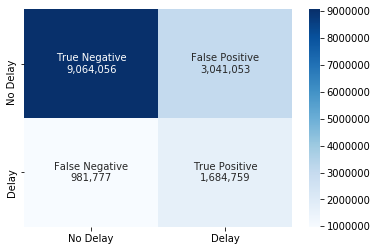

In [0]:
#Check for overfitting by fitting using model to make predictions on training data
predictions_on_train = gbtModel.transform(train_dataset_pca_ww)
display_metrics(predictions_on_train)

AUC: 0.743
precision: 0.353
recall: 0.652
accuracy: 0.689
F1 score: 0.458

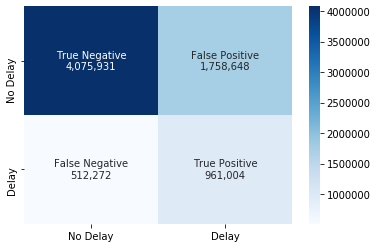

In [0]:
#Run final model on test data

#Create a vector of the numeric columns that need standardization
numericalColumns = ['CRS_ELAPSED_TIME', 'DISTANCE', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'TEMP', 'DEW_TEMP', 'SLPRESS', 'PAGERANK', 'DEST_LATITUDE', 'DEST_LONGITUDE', 'DEST_ELEVATION', 'DEST_TEMP', 'DEST_DEW_TEMP', 'DEST_SLPRESS']
numericalCols_vector = VectorAssembler(inputCols=numericalColumns, outputCol="numerical_features")
stages_standardize = [numericalCols_vector]

#Run pipeline to create vector of numeric columns in test data
partialPipeline_standardize = Pipeline().setStages(stages_standardize)
pipelineModel_standardize = partialPipeline_standardize.fit(test_data)
testData_standardize_vector = pipelineModel_standardize.transform(test_data)

#Standardize validation data - transform
testData_standardized = trainingData_standards.transform(testData_standardize_vector)

#Perform PCA on the numeric features
test_dataset_pca = pca_model.transform(testData_standardized)

#Run data through pipeline to assemble vector of categorical columns and PCA features
categoricalColumns = ["YEAR", "MONTH", "DAY_OF_WEEK", "OP_UNIQUE_CARRIER", "ORIGIN", "ORIGIN_STATE_ABR", "DEST", "DEST_STATE_ABR", "FIRST_DEP", "CRS_DEP_TIME_BUCK", "WND_SPEED_BUCK", "CIG_HEIGHT_BUCK", "VIS_DIST_BUCK", "PREVIOUS_DELAY", "VIS_VAR", "DEST_VIS_VAR", "DEST_WND_SPEED_BUCK", "DEST_VIS_DIST_BUCK", "DEST_CIG_HEIGHT_BUCK"]
numericCols = ["pcaFeatures"]
pipelineOutput = pipeline_helper_trees(categoricalColumns, numericCols)

#Fit and transform data using pipeline
train_dataset_pca_final, test_dataset_pca_final = pipeline_fit_transform(pipelineOutput, train_dataset_pca, test_dataset_pca)

#Cache prepared datasets
test_dataset_pca_final.cache()

# Make predictions on validation data using the Transformer.transform() method.
predictions_gbt_test = gbtModel.transform(test_dataset_pca_final)

#Display metrics
display_metrics(predictions_gbt_test)

# 6. Conclusions

To ensure that we had a good model that was not significantly underfitting or overfitting, we used our model to make predictions on the training data. We saw a 0.045 difference in accuracy between predictions on validation data as compared to training data. Since this is not a drastic difference, we can tell that our model is not significantly underfitting or overfitting.

In the confusion matrix above we see that of the flights that were actually delayed we are now predicting 65% of these as delays. This is a 20% improvement from our initial baseline model. We also see that we have optimized F1 score while also minimizing false negatives. We believe that a false negative is a worse scenario than a false positive, because with a false negative our model would predict that the flight is not delayed, but it actually ends up being delayed. This would not give the airline or passengers the opportunity to do something to mitigate the delay. Additionally, our F1 score is 0.458, which is a 0.045 improvement from our initial gradient boosted tree model. 

In the "Feature Importance" table above, we see that the most important feature is the departure time and the second most important feature is the feature we created indicating if the previous flight was delayed. It makes sense that whether or not the previous flight is delayed would have a large impact on whether or not the next flight is delayed, as it is difficult to stop the delay from propagating once it starts. We also see that the origin and destination airport are important features for determining delayed flights. We also see that the 6th most important feature is one of the features created through PCA, `pcaFeatures_0`. In the "PCA Feature Importance" table above, we see that the features: `TEMP`, `DEW_TEMP`, `DEST_TEMP`, `DEST_DEW_TEMP` were most important in `pcaFeatures_0`.

Using our model we can solve our original problem of predicting delays or cancellations 2 hours prior to a flight's departure. Using our model airlines could predict 2 hours prior to a flight's departure if a flight will be delayed by 15 or more minutes or cancelled with about 70% accuracy. Although this is not the most accurate model, we see that we have tried to minimize the false negative scenario of not predicting a delay, but the flight is actually delayed. Using our model, an airline and passengers can have confidence that they would have time to prepare for a delay. There may be some scenarios where our model predicts a delay, but the flight does not end up being delayed, but we believe it is better for the airline and passengers to be overprepared, rather than underprepared, especially since delayed flights result in high cost for the airlines and passengers.

Through our exploration and modeling to arrive at a final model, we learned that more is not always better. We found that even though we thought we had come up with some great engineered features, they didn't always result in improvement to our model's performance, and sometimes they even hurt the performance of our model. Along the same lines, we found that having a lot of features does not necessarily make the model better. Even though many features provides the model with a lot of information, it can make it difficult for the model to make good predictions. We saw improvements in our model when we reduced the number of features included. We also learned to be cognizant of overfitting. It can seem that adding more depth to a gradient boosted tree algorithm would result in better performance, but this was not always the case. It was also a difficult balance between trying to improve the model's performance and ensuring that our model was not too computationally intensive and was scalable. Even though gradient boosted trees train one tree at a time, we did not need as large of a tree depth as we may have needed with a random forest model, so this actually helped to reduce the amount of time our model took to run. Additionally, we found that the best way to work with this large dataset was to save everything and frequently to DBFS so that we don't have to shuffle as frequently, which is computationally intensive. We also found it very beneficial to always start our work in "a small world" and ensure our code was working properly with only a small subset of the data. This allowed us to find issues in our code and fix them faster.

There are several ways in which our model could still be improved upon. Potentially more features could be engineered and added to the model, such as rather than the feature that we tried of purely number of flights per day across all airports, a feature could be created that has the flights per day per airport or per airline or per tail number. This may help to improve the model's performance. Additionally, more tuning could be done to our model to adjust the max depth, minimum instances per node, maximum iterations or possibly look at early stopping. The entire end to end pipeline of our model could be improved by splitting the data into train, test, and validation at the very beginning of the process, but this would result in the joining of the airlines and weather data being more computationally intensive. There were also some scenarios in our data cleansing and preprocessing where we dropped certain rows of data from the training set, but our process could be improved to consider and handle more of these edge cases rather than dropping the data.

# 7. Application of Course Concepts

**Directed Acyclic Graphs (DAGs)**  
One of the key concepts in the parallel computation framework is the DAG, short for directed-acyclic-graph. In layman's term, the commands a programmer writes would go through a series of steps that could depend on the preceeding comand. Raw data can be sent to the DAG and run through the series of step and output something else but it would not be sent back to the beginning of the DAG. In Hadoop and Spark, the nodes in the DAG represents tasks while the edges are the task dependencies.  
In this project, we used many pyspark commands such as a `.count()`. Early in the project, to check for errors, we utilized `.count()` at every step of the pipeline which took a lot of time to produce a result. Because we understood the concept of a DAG, we realized that at each call of a `.count()`, it was re-running the entire preceding pipeline. Therefore, each incremental `.count()` call was increasing the total compute time. To solve this, we stored/wrote each step of the pipeline into the databricks database (DBFS) and then read the saved file and continue on with the pipeline.  At one point, a series of x10 `.count()` took over 3 hours and after implementing this strategy, the same x10 `.count()` completed in minutes. 

**One Hot Encoding & Breiman's Method**  
We used the method of one hot encoding specifically for regression. One hot encoding is the process of transforming a \\(k\\)-class categorical variable into \\(k-1\\) binary variables capturing the same information. Logistic regression requires all inputted features to be numerical, so one hot encoding allowed us to include categorical features we felt would be important for predicting flight delays. For example, there are 19 different airlines included in the airline data, so we one hot encoded the airline feature into 18 binary airline features. 

Decision tree, random forest and gradient boosted tree algorithms do not require the data to be one hot encoded. We tried running these algorithms with and without one hot encoding the categorical features and we found that it was beneficial to not one hot encode the categorical features for these models. Leaving the categorical features as is and not one hot encoding them enabled Spark to employ Brieman's Theorem when determining the best split points for the categorical attributes. This helped to reduce the time it took to train our algorithm because it allowed the algorithm to find the best split predicate for a categorical attribute without having to evaluate all possible subsets of each category.

**Bias-Variance Tradeoff**  
The bias-variance tradeoff was considered when tuning the machine learning models. Essentially, high-variance can lead to over-fitting while high-bias can lead to under-fitting. In general, we expect model prediction on training data to be better than validation data. However, if the training data predictions continued to improve but the validation data prediction started to worsen, then the model could be overfitting and capturing too much variance in the training data. On the other end, if the predictions for both training and validation data worsen, it could be a case of under-fitting and the model is not capturing enough variance. Some specific tasks that were done in the project to balance bias and variance were to create additional features, selecting a machine learning algorithm, hyper-parameter tuning, feature transformations/engineering, and Principal Component Analysis (PCA). By creating additional features, we helped the machine learning model capture more variances in the dataset that otherwise might not have been picked up (easily). By selecting gradient boosted trees, the boosting technique would reduce the bias and capture variances from the weak learners (using weights). By tuning the hyperparameters, we also varied the amount of variance versus bias. Specifically, a larger depth in the tree, a larger max_iterations, a smaller min_sample_split, or a smaller minimum_instances_per_node would capture more variance. By transforming features to different granularity such as increasing the number of bins in categorical data, would increase variance. By using Principal Component Analysis (PCA) to reduce dimensions in the data, we decreased the variance and increased the bias of our model.  

**The Shuffle**  
The shuffle is a crucial but costly component of map reduce frameworks where records starting off on separate partitions but need to end up on the same reducer for the given computation are sent across the network. Since communication across the network is costly, we minimized the amount of shuffling in our data joins.  Where possible, we implemented broadcast hash joins to avoid a full shuffle. For example, when we calculated each airport’s PageRank, we created a small table of airport and PageRank that fit in memory and joined that small table with our large full data table. Since the lookup table fit in memory, all PageRanks were available on all partitions for joining, so no network communication was required to add PageRank to the feature table. When that wasn’t possible, we used inner joins. To combine our 30+ million rows of flight data with 22+ million rows of weather data, a shuffle was required.

# Complete Pipeline Instructions

Here, we explain how to predict if a flight is going to be delayed, 2-hours prior to schedule departure time. While this specific pipeline design may not be the most efficient, it was created by taking into account the limited compute resources (of a shared cluster) and minimizing the time spent waiting for commands to run. In production, we would ideally split the raw data into training, validation, and testing data at the very beginning instead of this design of processing the data first and then splitting.  

To begin, the flight and weather data would both be provided along with the rest of the raw training data in the same format as the current raw training data.  

The flight data would be sent to this notebook:  
Phase 1  - Full Flights Data - Processing and Storing to Database:  
https://dbc-c4580dc0-018b.cloud.databricks.com/?o=8229810859276230#notebook/2158640876508903/command/2158640876508904  

The weather data would be sent to this notebook:  
Phase 1 - Weather Data - Processing and Storing to Database  
https://dbc-c4580dc0-018b.cloud.databricks.com/?o=8229810859276230#notebook/2158640876507578  

After running all the commands in Phase 1, we would click run all in Phase 2 notebook.  
Phase 2 - Flights & Weather Data - Join  
https://dbc-c4580dc0-018b.cloud.databricks.com/?o=8229810859276230#notebook/2158640876511106/command/4061768275130924

After Phase 2, we would click run all in Phase 3 - Train Split if we wish to update the training data.  
Phase 3 - Train Split    
https://dbc-c4580dc0-018b.cloud.databricks.com/?o=8229810859276230#notebook/2158640876511176/command/2158640876511177

If we do not need to update the training data, we can just run Phase 3 - Validation&Test Split.  
Phase 3 - Validation&Test Split  
https://dbc-c4580dc0-018b.cloud.databricks.com/?o=8229810859276230#notebook/3450569410557553/command/3450569410557556

After Phase 3, we would have the following data saved in DBFS in databricks.  
`train_data` which is used to train the models.   
`validation_data`  which is used to tune the models.  
`test_data`  which is used to test the model.  The flight that needs a delayed prediction would be located in this test_data.  

With these data stored, we can run this current notebook on Section 5. Algorithm Implementation.

# Bibliography

\\(^1\\)Lukacs, Michael. “Cost of Delay Estimates.” FAA, 2019, www.faa.gov/data_research/aviation_data_statistics/media/cost_delay_estimates.pdf.  

\\(^2\\)“OST_R: BTS: Transtats.” BTS, 2020, www.transtats.bts.gov/DatabaseInfo.asp?DB_ID=120. 

\\(^3\\)“Land-Based Datasets and Products.” National Climatic Data Center, 2020, www.ncdc.noaa.gov/data-access/land-based-station-data/land-based-datasets. 

\\(^4\\)Belcastro, Loris, et al. Using Scalable Data Mining for Predicting Flight Delays. Dec. 2014.   

\\(^5\\)Chakrabarty, Navoneel. A Data Mining Approach to Flight Arrival Delay Prediction for American Airlines.